## Colab Setup

In [1]:
import sys

IS_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IS_COLAB}")

Running in Google Colab: True


In [2]:
import os
import sys

if IS_COLAB:
    print("Running in Google Colab environment.")
    if os.path.exists('/content/aai521_3proj'):
        print("Repository already exists. Pulling latest changes...")
        %cd /content/aai521_3proj
        !git pull
    else:
        print("Cloning repository...")
        !git clone https://github.com/swapnilprakashpatil/aai521_3proj.git
        %cd aai521_3proj    
    %pip install -r requirements.txt
    sys.path.append('/content/aai521_3proj/src')
    %ls
else:
    print("Running in local environment. Installing packages...")
    %pip install -r ../requirements.txt
    sys.path.append('../src')

Running in Google Colab environment.
Repository already exists. Pulling latest changes...
/content/aai521_3proj
Already up to date.
dataset/  notebooks/  requirements.txt  src/


In [3]:
import platform
import psutil
import subprocess
import os

if IS_COLAB:
    print("Google Colab Environment Specifications:")
    print("="*50)
    
    # Get system info
    
    print(f"Operating System: {platform.system()} {platform.release()}")
    print(f"Architecture: {platform.machine()}")
    print(f"Python Version: {platform.python_version()}")
    
    # Memory info
    memory = psutil.virtual_memory()
    print(f"Total RAM: {memory.total / (1024**3):.1f} GB")
    print(f"Available RAM: {memory.available / (1024**3):.1f} GB")
    
    # CPU info
    print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    
    # GPU info
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            gpu_info = result.stdout.strip().split('\n')
            for i, gpu in enumerate(gpu_info):
                name, memory = gpu.split(', ')
                print(f"GPU {i}: {name}, {memory} MB VRAM")
        else:
            print("GPU: Not detected or nvidia-smi unavailable")
    except:
        print("GPU: Not detected")
    
    # Disk space
    disk = psutil.disk_usage('/')
    print(f"Disk Space: {disk.free / (1024**3):.1f} GB free / {disk.total / (1024**3):.1f} GB total")
    
    print("="*50)

    if not os.path.exists('/content/aai521_3proj'):
        print("WARNING: Cloning project repository required.")
        print("="*50)
else:
    print("Not running in Google Colab environment")

Google Colab Environment Specifications:
Operating System: Linux 6.6.105+
Architecture: x86_64
Python Version: 3.12.12
Total RAM: 83.5 GB
Available RAM: 80.3 GB
CPU Cores: 6 physical, 12 logical
GPU 0: NVIDIA A100-SXM4-40GB, 40960 MB VRAM
Disk Space: 91.4 GB free / 235.7 GB total


## 1. Setup & Imports

In [4]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Reload modules to pick up latest changes
import importlib
if 'dataset' in sys.modules:
    importlib.reload(sys.modules['dataset'])
if 'models' in sys.modules:
    importlib.reload(sys.modules['models'])
if 'config' in sys.modules:
    importlib.reload(sys.modules['config'])

# Import custom modules
import config
from dataset import create_dataloaders, FloodDataset
from models import create_model, UNetPlusPlus, DeepLabV3Plus, SegFormer
from losses import create_loss_function
from metrics import MetricsTracker, SegmentationMetrics
from trainer import Trainer
from experiment_tracking import ExperimentLogger, ExperimentComparator
from gpu_manager import GPUManager

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Initialize GPU manager
gpu_mgr = GPUManager()
gpu_mgr.setup()
gpu_mgr.print_nvidia_smi_info()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {gpu_mgr.is_available()}")
if gpu_mgr.is_available():
    print(f"CUDA device: {gpu_mgr.gpu_name}")
    print(f"CUDA memory: {gpu_mgr.total_memory_gb:.2f} GB")

GPU 0: NVIDIA A100-SXM4-40GB, 40960 MB VRAM
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
CUDA memory: 42.47 GB


## 2. Data Loading & Exploration

In [5]:
# Print GPU information and clear up
gpu_mgr.print_info()
gpu_mgr.print_memory_stats()
gpu_mgr.cleanup()

CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
CUDA memory: 42.47 GB

GPU Memory Usage: Allocated: 0.00 GB, Reserved: 0.00 GB, Free: 42.47 GB, Total: 42.47 GB


### Visualize Class Distribution

In [6]:
# Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dir=config.PROCESSED_TRAIN_DIR,
    val_dir=config.PROCESSED_VAL_DIR,
    test_dir=config.PROCESSED_TEST_DIR,
    batch_size=8,
    num_workers=0,  # Set to 0 for Colab to avoid worker crashes
    pin_memory=False  # Disabled for Colab stability
)

# Calculate class weights from training data
print("\nCalculating class weights from training data...")
class_counts = torch.zeros(config.NUM_CLASSES)

for batch in tqdm(train_loader, desc="Computing class distribution"):
    masks = batch['mask']
    for cls in range(config.NUM_CLASSES):
        class_counts[cls] += (masks == cls).sum()

# Check for missing classes
print("\nRaw class counts:")
for cls, (name, count) in enumerate(zip(config.CLASS_NAMES, class_counts)):
    print(f"  {name}: {count:.0f} pixels")

# Compute weights (inverse frequency) with protection against division by zero
total_pixels = class_counts.sum()
class_weights = torch.zeros(config.NUM_CLASSES)

for cls in range(config.NUM_CLASSES):
    if class_counts[cls] > 0:
        class_weights[cls] = total_pixels / (config.NUM_CLASSES * class_counts[cls])
    else:
        # If class is missing, assign median weight to avoid NaN
        print(f"WARNING: Class {cls} ({config.CLASS_NAMES[cls]}) has 0 samples!")
        class_weights[cls] = 1.0  # Will be normalized later

# Normalize weights
weight_sum = class_weights.sum()
if weight_sum > 0:
    class_weights = class_weights / weight_sum * config.NUM_CLASSES
else:
    # Fallback to uniform weights if all classes missing (shouldn't happen)
    class_weights = torch.ones(config.NUM_CLASSES)

# Cap extreme weights to prevent numerical instability
max_weight = 10.0
class_weights = torch.clamp(class_weights, min=0.1, max=max_weight)

print("\nClass distribution and weights (after capping):")
for cls, (name, count, weight) in enumerate(zip(config.CLASS_NAMES, class_counts, class_weights)):
    pct = (count / total_pixels * 100).item() if total_pixels > 0 else 0.0
    print(f"  {name}: {count:.0f} pixels ({pct:.2f}%), weight: {weight:.4f}")

print(f"\nDataloaders created:")
print(f"  Train: {len(train_loader)} batches ({len(train_loader.dataset)} samples)")
print(f"  Val: {len(val_loader)} batches ({len(val_loader.dataset)} samples)")
print(f"  Test: {len(test_loader)} batches ({len(test_loader.dataset)} samples)")

Creating dataloaders...
Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weig

Computing class distribution:   0%|          | 0/910 [00:00<?, ?it/s]


Raw class counts:
  0: 1862348544 pixels
  1: 30064482 pixels
  2: 8342595 pixels
  3: 0 pixels
  4: 0 pixels
  5: 1743579 pixels
  6: 5909875 pixels

Class distribution and weights (after capping):
  0: 1862348544 pixels (97.59%), weight: 0.1000
  1: 30064482 pixels (1.58%), weight: 0.2576
  2: 8342595 pixels (0.44%), weight: 0.9284
  3: 0 pixels (0.00%), weight: 0.1000
  4: 0 pixels (0.00%), weight: 0.1000
  5: 1743579 pixels (0.09%), weight: 4.4423
  6: 5909875 pixels (0.31%), weight: 1.3106

Dataloaders created:
  Train: 910 batches (7285 samples)
  Val: 136 batches (1087 samples)
  Test: 447 batches (3573 samples)


### Visualize Sample Data

Batch shape: torch.Size([8, 6, 512, 512])
Mask shape: torch.Size([8, 512, 512])
Image range: [-2.118, -2.018]
Mask classes: [0, 1, 5, 6]


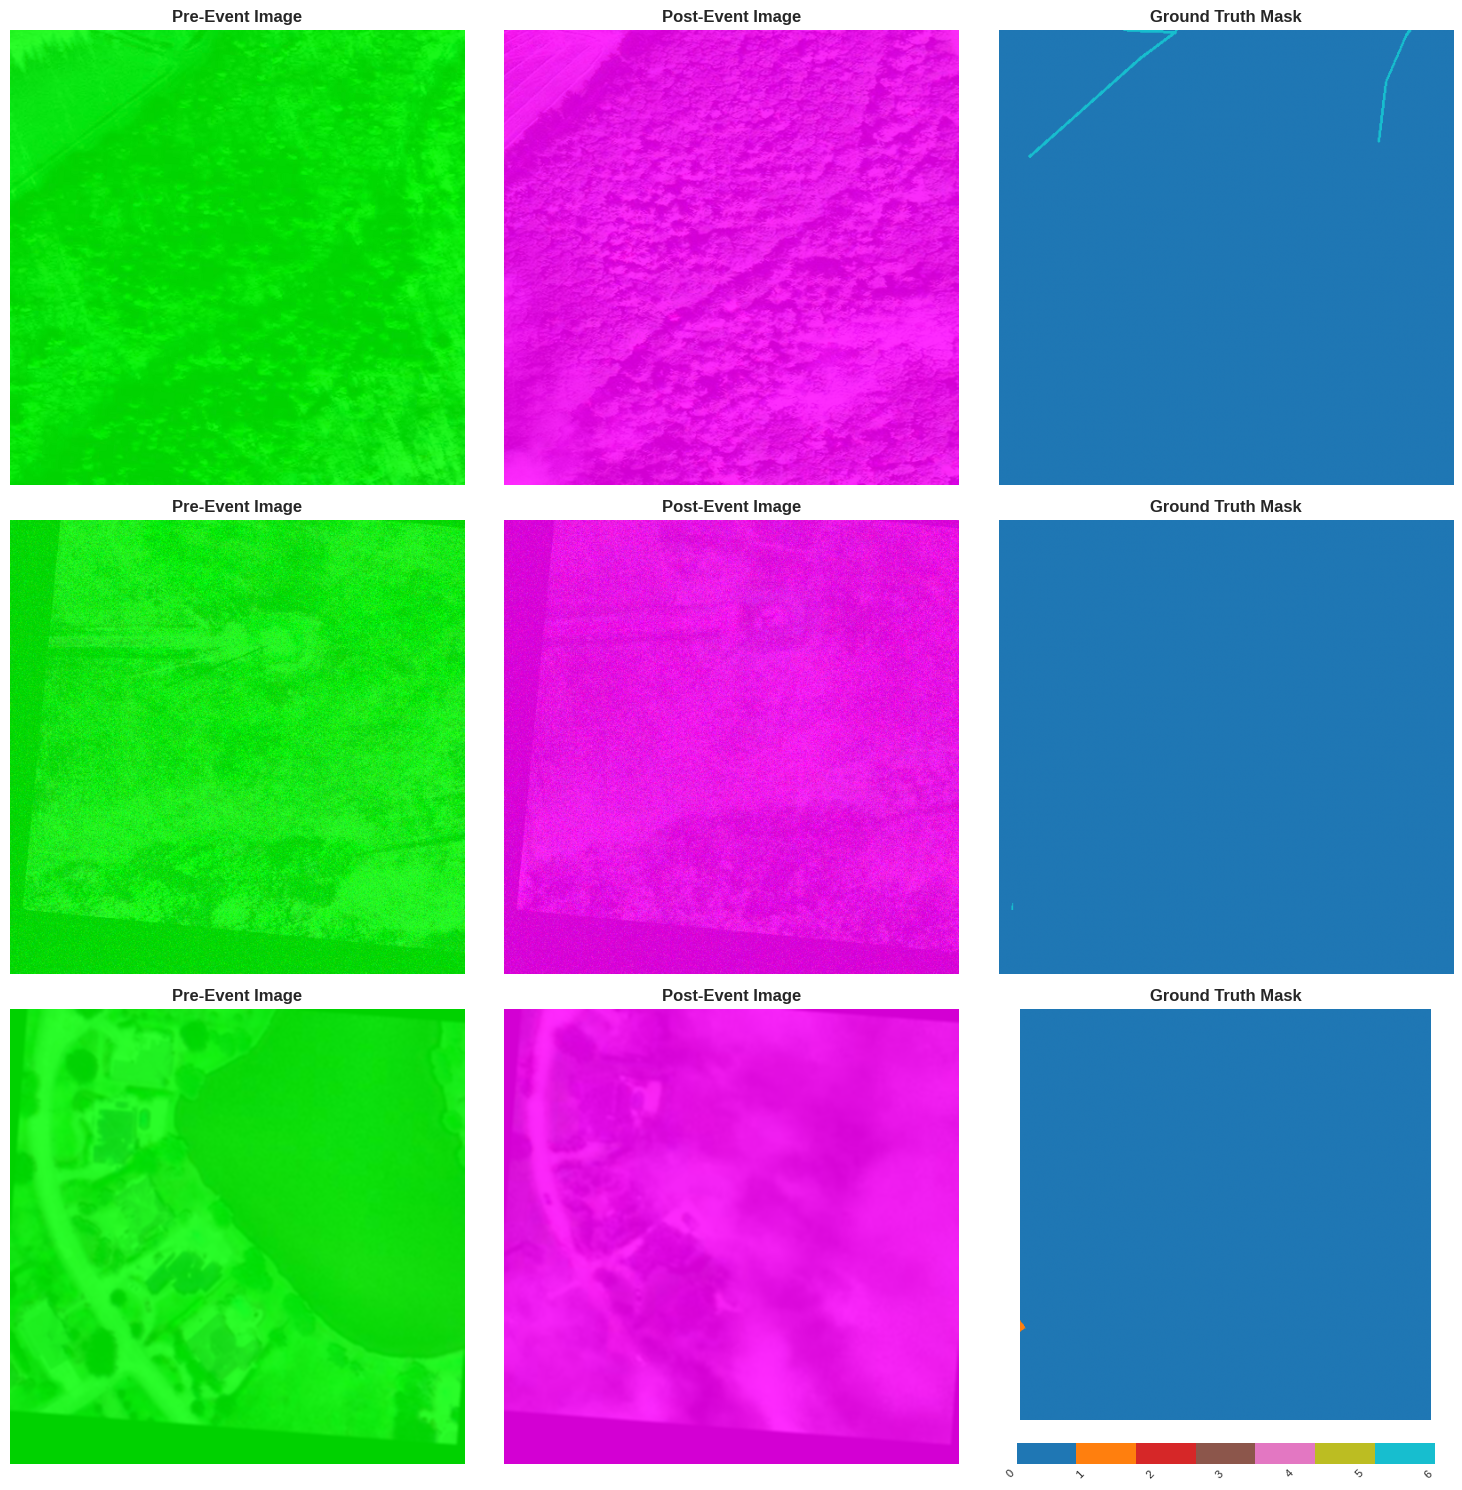

In [7]:
# Get a batch of training data
train_iter = iter(train_loader)
batch = next(train_iter)
images = batch['image']
masks = batch['mask']

print(f"Batch shape: {images.shape}")
print(f"Mask shape: {masks.shape}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Mask classes: {masks.unique().tolist()}")

# Visualize samples
def visualize_samples(images, masks, num_samples=3):
    """Visualize pre/post images and masks."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Color map for masks
    cmap = plt.cm.get_cmap('tab10', len(config.CLASS_NAMES))
    
    for i in range(num_samples):
        # Pre-event image (first 3 channels)
        pre_img = images[i, :3].permute(1, 2, 0).numpy()
        pre_img = (pre_img - pre_img.min()) / (pre_img.max() - pre_img.min() + 1e-8)
        
        # Post-event image (last 3 channels)
        post_img = images[i, 3:].permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-8)
        
        # Mask
        mask = masks[i].numpy()
        
        # Plot pre-event
        axes[i, 0].imshow(pre_img)
        axes[i, 0].set_title('Pre-Event Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Plot post-event
        axes[i, 1].imshow(post_img)
        axes[i, 1].set_title('Post-Event Image', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Plot mask
        mask_plot = axes[i, 2].imshow(mask, cmap=cmap, vmin=0, vmax=len(config.CLASS_NAMES)-1)
        axes[i, 2].set_title('Ground Truth Mask', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Add colorbar to last mask
        if i == num_samples - 1:
            cbar = plt.colorbar(mask_plot, ax=axes[i, 2], orientation='horizontal', 
                              pad=0.05, fraction=0.046)
            cbar.set_ticks(range(len(config.CLASS_NAMES)))
            cbar.set_ticklabels(config.CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks, num_samples=3)

## 3. Model Architecture Overview

In [8]:
# Create models for architecture overview
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# List of all models to train
ALL_MODELS = ['unet++', 'deeplabv3+', 'segformer', 'fc_siam_diff', 'siamese_unet++', 'stanet']

models_info = []

for model_name in ALL_MODELS:
    model = create_model(
        model_name=model_name,
        in_channels=6 if 'siamese' not in model_name.lower() else 3,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models_info.append({
        'Model': model_name.upper(),
        'Total Parameters': f"{total_params:,}",
        'Trainable Parameters': f"{trainable_params:,}",
        'Size (MB)': f"{total_params * 4 / 1e6:.2f}"
    })
    
    del model

# Display as table
models_df = pd.DataFrame(models_info)
print("\n" + "="*80)
print("MODEL ARCHITECTURE COMPARISON")
print("="*80)
print(models_df.to_string(index=False))
print("="*80)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([7, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegFormer initialized:
  Model: nvidia/segformer-b0-finetuned-ade-512-512
  Input channels: 6
  Output classes: 7
  Pretrained: True
FC-Siam-Diff initialized:
  Encoder: resnet34
  Optimized for change detection
Siamese U-Net++ initialized:
  Encoder: resnet34
  Fusion: concat
  Output classes: 7
STANet initialized with spatial-temporal attention

MODEL ARCHITECTURE COMPARISON
         Model Total Parameters Trainable Parameters Size (MB)
        UNET++       26,088,887           26,088,887    104.36
    DEEPLABV3+       26,688,535           26,688,535    106.75
     SEGFORMER        3,720,647            3,720,647     14.88
  FC_SIAM_DIFF       24,584,519           24,584,519     98.34
SIAMESE_UNET++       26,780,167           26,780,167    107.12
        STANET       24,890,824           24,890,824     99.56


## 4. Training Configuration

In [9]:
# Setup device using GPU manager
device = gpu_mgr.get_device()
print(f"Using device: {device}")

# Training configurations
LIGHT_CONFIG = {
    'num_epochs': 3,
    'batch_size': 8,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'device': device,
    'use_amp': True,
    'gradient_clip': 1.0,
    'max_batches_per_epoch': 50,
    'loss_type': 'combined',
    'early_stopping_patience': 5,
}

TRAINING_CONFIG = {
    'num_epochs': 20,
    'batch_size': 64,  # Increased from 32 for A100 (40GB VRAM) - maximize GPU utilization!
    'learning_rate': 1e-4,  # Increased from 1e-5 with larger batch size
    'weight_decay': 1e-4,
    'device': device,
    'use_amp': True,
    'gradient_clip': 1.0,
    'gradient_accumulation_steps': 1,  # Reduced from 2 since batch size increased to 64
    'loss_type': 'dice',  # Simplified from 'combined' to most stable loss
    'early_stopping_patience': 5,
    # Reduced complexity for combined loss (if switched back)
    'ce_weight': 0.1,
    'dice_weight': 1.0,  # Reduced from 2.0
    'focal_weight': 1.0,  # Reduced from 3.0
    'focal_gamma': 2.0,  # Reduced from 3.0
}

print("Configuration loaded:")
print(f"  Light validation: {LIGHT_CONFIG['num_epochs']} epochs, {LIGHT_CONFIG['max_batches_per_epoch']} batches/epoch")
print(f"  Full training: {TRAINING_CONFIG['num_epochs']} epochs, early stop patience={TRAINING_CONFIG['early_stopping_patience']}")

Using device: cuda
Configuration loaded:
  Light validation: 3 epochs, 50 batches/epoch
  Full training: 20 epochs, early stop patience=5


In [10]:
# Check GPU memory and recommend optimal batch size
if gpu_mgr.is_available():
    recommended_batch = gpu_mgr.recommend_batch_size()
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_num_threads(8)
    print(f"GPU: {gpu_mgr.gpu_name}")
    print(f"Total Memory: {gpu_mgr.total_memory_gb:.2f} GB")
    print(f"Recommended batch size: {recommended_batch}")
    print(f"Current batch size: {TRAINING_CONFIG['batch_size']}")
    print(f"Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")        
    # Monitor current GPU state
    gpu_mgr.cleanup()
    stats = gpu_mgr.get_memory_stats()
    print(f"\nCurrent GPU Usage: Allocated: {stats['allocated_gb']:.2f} GB, Reserved: {stats['reserved_gb']:.2f} GB, Free: {stats['free_gb']:.2f} GB")
else:
    print("No GPU available - using CPU")

GPU: NVIDIA A100-SXM4-40GB
Total Memory: 42.47 GB
Recommended batch size: 64
Current batch size: 64
Effective batch size: 64

Current GPU Usage: Allocated: 0.00 GB, Reserved: 0.00 GB, Free: 42.47 GB


## 5. Light Pipeline Validation

Quickly validate that all models can train without errors before committing to full training.

In [11]:
# Import light pipeline
from light_pipeline import LightPipeline

print("Light pipeline class loaded.")

# Run light validation pipeline for all models
light_pipeline = LightPipeline(LIGHT_CONFIG, class_weights)

# Validate all models
validation_results = light_pipeline.validate_all_models(
    ALL_MODELS,
    train_loader,
    val_loader
)

# Access results
passed_models = light_pipeline.get_passed_models()
failed_models = light_pipeline.get_failed_models()

print(f"\nReady to proceed with {len(passed_models)} validated models.")

Light pipeline class loaded.

LIGHT PIPELINE VALIDATION - Testing all models can train
Config: 3 epochs, 50 batches/epoch
Expected time: ~2-3 minutes per model, ~15 minutes total


Validating UNET++
UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.1        0.25763178 0.9284361  0.1        0.1        4.4423375
 1.3106143 ]
  Epoch 1/3: Loss=2.5063
  Epoch 2/3: Loss=2.3338
  Epoch 3/3: Loss=2.2616
  [PASSED] (111.2s) - Final Loss: 2.2616

Validating DEEPLABV3+
DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet
Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.1        0.25763178 0.9284361  0.1        0.1        4.4423375
 1.3106143 ]
  Epoch 1/3: Loss=2.2341
  Epoch 2/3: Lo

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([7, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegFormer initialized:
  Model: nvidia/segformer-b0-finetuned-ade-512-512
  Input channels: 6
  Output classes: 7
  Pretrained: True
Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.1        0.25763178 0.9284361  0.1        0.1        4.4423375
 1.3106143 ]
  Epoch 1/3: Loss=2.3517
  Epoch 2/3: Loss=2.1866
  Epoch 3/3: Loss=2.0692
  [PASSED] (72.0s) - Final Loss: 2.0692

Validating FC_SIAM_DIFF
FC-Siam-Diff initialized:
  Encoder: resnet34
  Optimized for change detection
Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.1        0.25763178 0.9284361  0.1        0.1        4.4423375
 1.3106143 ]
  Epoch 1/3: Loss=2.6563
  Epoch 2/3: Loss=2.5765
  Epoch 3/3: Loss=2.5387
  [PASSED] (85.4s) - Final Loss: 2.5387

Validating SIAMESE_UNET++
Siamese U-Net++ initialized:
  Encoder: resnet34
  Fusion: concat
  Output classes: 7
Combined Loss initialized:
  CE weight:    0.1
  Dice 

### Validation Performance Comparison

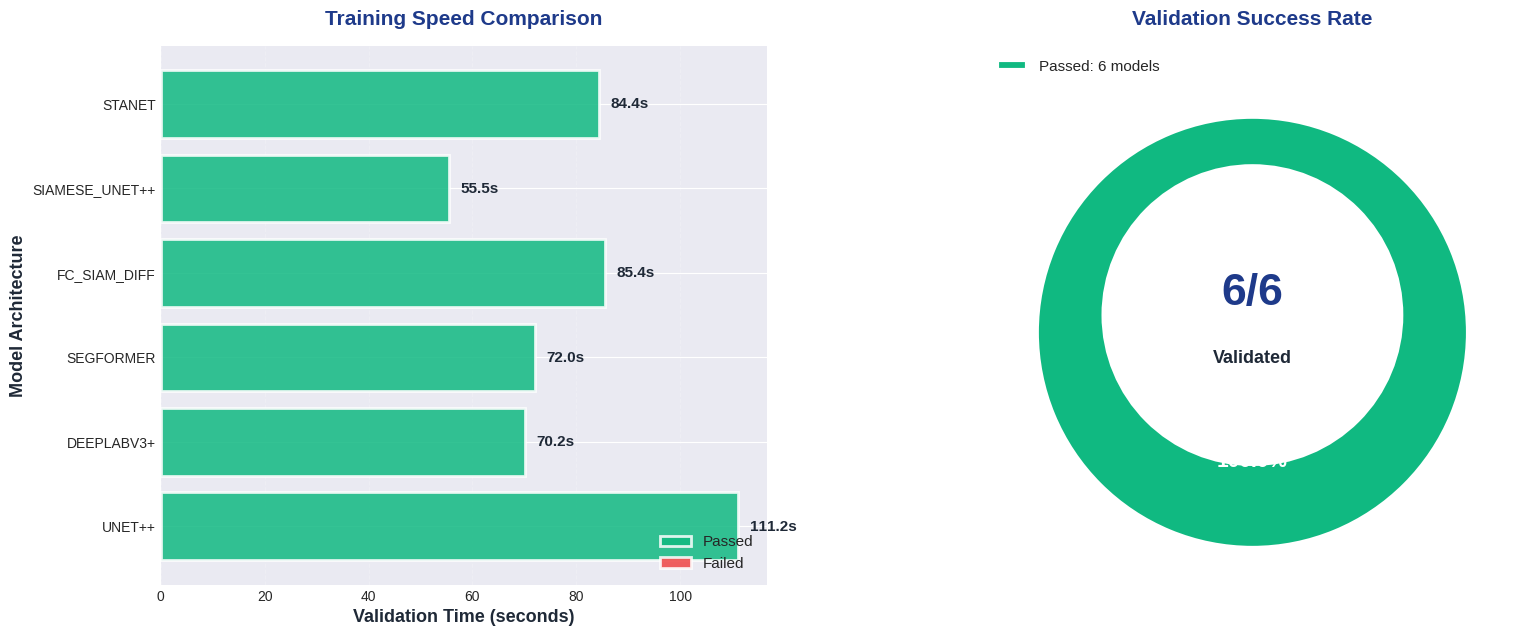

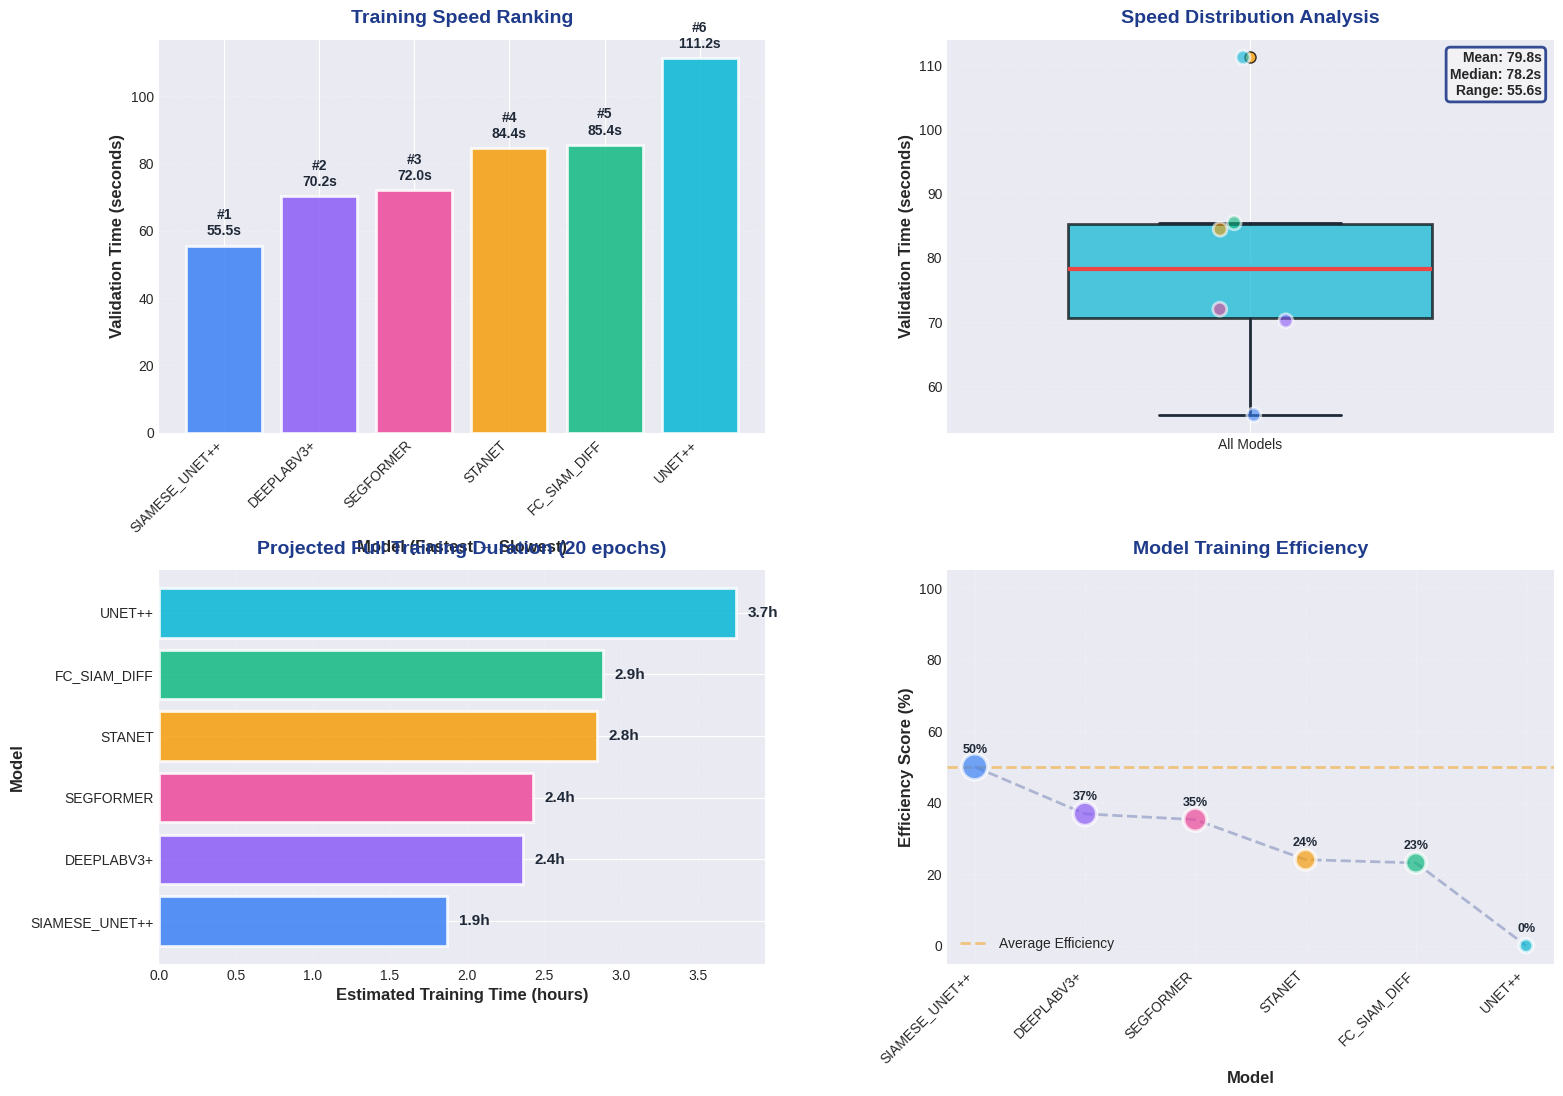

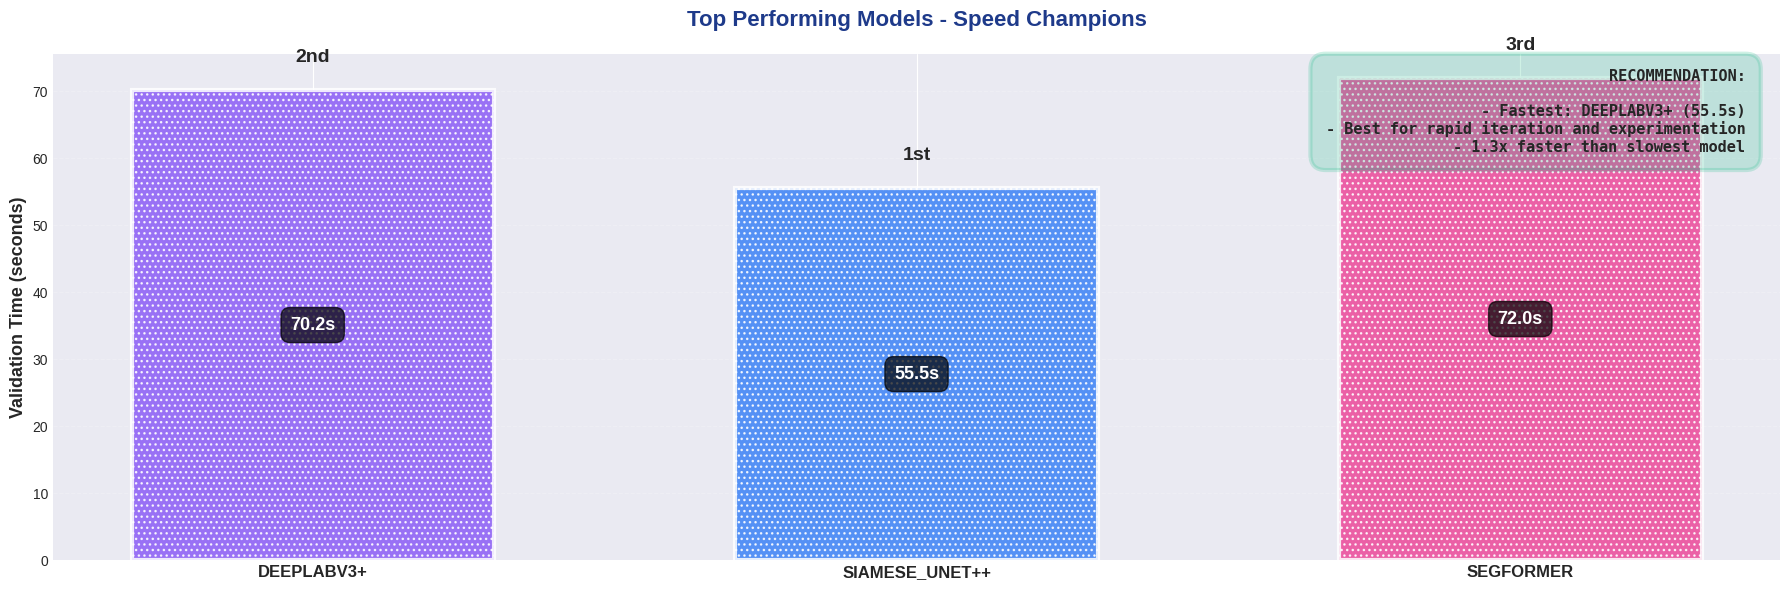


VALIDATION PERFORMANCE ANALYSIS

Passed Models Statistics (6 models):
   • Average time:    79.8s
   • Fastest:         SIAMESE_UNET++ (55.5s)
   • Slowest:         UNET++ (111.2s)
   • Time range:      55.5s - 111.2s
   • Std deviation:   ±17.2s
   • Speed variation: 100.2% difference

Estimated Full Training Time (20 epochs, full dataset):
   • Per model (avg):     ~2.7 hours
   • All 6 models:        ~16.1 hours
   • Sequential training: ~16.1 hours
   • Parallel (3 pairs):  ~5.4 hours

Efficiency Insights:
   • SIAMESE_UNET++ is 2.0x faster than UNET++
   • Time saved by choosing fastest: 55.6s per validation

Top Recommendations:
   Rank 1: SIAMESE_UNET++ - 55.5s (Efficiency: 50%)
   Rank 2: DEEPLABV3+ - 70.2s (Efficiency: 37%)
   Rank 3: SEGFORMER - 72.0s (Efficiency: 35%)



In [12]:
# Import visualization utilities
from visualizations import ValidationVisualizer

# Create visualizer instance
viz = ValidationVisualizer()

# Visualize validation results with comprehensive analysis
if validation_results:
    # Figure 1: Training Speed & Success Rate Overview
    viz.plot_validation_overview(validation_results, ALL_MODELS)
    
    # Figure 2: Learning Progress & Convergence Analysis
    viz.plot_learning_analysis(validation_results, ALL_MODELS, len(train_loader))
    
    # Figure 3: Top Performers Podium
    viz.plot_top_performers(validation_results, ALL_MODELS)
    
    # Print detailed statistics
    viz.print_validation_statistics(validation_results, ALL_MODELS, len(train_loader))
else:
    print("No validation results available for visualization.")

## 6. Training Function

In [13]:
def train_model(model_name, config_dict, train_loader, val_loader, class_weights, resume_from_checkpoint=None):
    """Train a single model and return training history.
    
    Args:
        model_name: Name of the model to train
        config_dict: Training configuration dictionary
        train_loader: Training data loader
        val_loader: Validation data loader
        class_weights: Class weights for loss function
        resume_from_checkpoint: Path to checkpoint file to resume training from
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*80}\n")
    
    # CUDA optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    # Create output directory or use existing for resume
    if resume_from_checkpoint:
        # Extract output dir from checkpoint path
        checkpoint_path = Path(resume_from_checkpoint)
        output_dir = checkpoint_path.parent.parent
        checkpoint_dir = checkpoint_path.parent
        print(f"Resuming from checkpoint: {checkpoint_path}")
    else:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = Path('../outputs/training') / f'{model_name}_{timestamp}'
        output_dir.mkdir(parents=True, exist_ok=True)
        checkpoint_dir = output_dir / 'checkpoints'
        checkpoint_dir.mkdir(exist_ok=True)
    
    # Clear GPU memory before creating model
    if config_dict['device'] == 'cuda':
        try:
            torch.cuda.empty_cache()
            import gc
            gc.collect()
        except:
            pass
    
    # Create model
    model = create_model(
        model_name=model_name,
        in_channels=6 if 'siamese' not in model_name.lower() else 3,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    
    # Move model to device with proper handling for meta tensors
    if config_dict['device'] == 'cuda':
        # First move to CPU if needed, then to CUDA to avoid meta tensor issues
        model = model.cpu()
        
        # Clear GPU cache again before moving to CUDA
        try:
            torch.cuda.empty_cache()
            gc.collect()
        except:
            pass
        
        model = model.to(config_dict['device'])
    else:
        model = model.to(config_dict['device'])
    
    # Use torch.compile if available (disabled for now to avoid issues)
    # if hasattr(torch, 'compile') and config_dict['device'] == 'cuda':
    #     try:
    #         model = torch.compile(model, mode='default')
    #     except Exception as e:
    #         pass
    
    # Create loss function
    loss_fn = create_loss_function(
        loss_type=config_dict['loss_type'],
        num_classes=config.NUM_CLASSES,
        class_weights=class_weights.to(config_dict['device']),
        device=config_dict['device'],
        ce_weight=config_dict.get('ce_weight', 0.1),
        dice_weight=config_dict.get('dice_weight', 2.0),
        focal_weight=config_dict.get('focal_weight', 3.0),
        focal_gamma=config_dict.get('focal_gamma', 3.0)
    )
    
    # Create optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config_dict['learning_rate'],
        weight_decay=config_dict['weight_decay']
    )
    
    # Create learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3
    )
    
    # Create experiment logger
    from experiment_tracking import ExperimentLogger
    log_dir = Path('../outputs/tensorboard')
    log_dir.mkdir(parents=True, exist_ok=True)
    logger = ExperimentLogger(
        log_dir=log_dir,
        experiment_name=f'{model_name}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )
    
    # Load checkpoint if resuming
    start_epoch = 0
    best_val_iou = 0.0
    if resume_from_checkpoint:
        checkpoint = torch.load(resume_from_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
        best_val_iou = checkpoint.get('best_val_iou', 0.0)
        print(f"Resuming from epoch {start_epoch}, best IoU: {best_val_iou:.4f}")
    
    # Create trainer
    experiment_name = f"{model_name}_{output_dir.name.split('_', 1)[1]}" if resume_from_checkpoint else f'{model_name}_{timestamp}'
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        num_classes=config.NUM_CLASSES,
        device=config_dict['device'],
        checkpoint_dir=checkpoint_dir,
        experiment_name=experiment_name,
        use_amp=config_dict['use_amp'],
        gradient_clip_val=config_dict['gradient_clip'],
        early_stopping_patience=config_dict['early_stopping_patience'],
        gradient_accumulation_steps=config_dict.get('gradient_accumulation_steps', 1),
        class_names=config.CLASS_NAMES
    )
    
    # Train (adjust epochs if resuming)
    remaining_epochs = config_dict['num_epochs'] - start_epoch
    if remaining_epochs > 0:
        history = trainer.train(num_epochs=remaining_epochs)
    else:
        print(f"Training already completed ({start_epoch} epochs). Skipping.")
        return None, output_dir
    
    # Print final summary
    best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
    print(f"\n{'='*80}")
    print(f"FINAL RESULTS - {model_name.upper()}")
    print(f"{'='*80}")
    print(f"Best epoch: {best_epoch + 1}/{len(history['val_iou'])}")
    print(f"\nBest validation metrics:")
    print(f"  IoU:  {history['val_iou'][best_epoch]:.4f}")
    print(f"  Dice: {history['val_dice'][best_epoch]:.4f}")
    print(f"  F1:   {history['val_f1'][best_epoch]:.4f}")
    print(f"\n{'='*80}")
    # Per-class metrics if available
    if 'val_iou_per_class' in history:
        print(f"\nPer-class IoU (Best Epoch):")
        for i, (class_name, iou) in enumerate(zip(config.CLASS_NAMES, history['val_iou_per_class'][best_epoch])):
            print(f"  {class_name}: {iou:.4f}")
    
    print(f"{'='*80}\n")
    
    # Log metrics to TensorBoard
    for epoch in range(len(history['train_loss'])):
        logger.log_scalar('Loss/train', history['train_loss'][epoch], epoch)
        logger.log_scalar('Loss/val', history['val_loss'][epoch], epoch)
        logger.log_scalar('IoU/train', history['train_iou'][epoch], epoch)
        logger.log_scalar('IoU/val', history['val_iou'][epoch], epoch)
    
    logger.close()
    
    # Save history
    history_json = {}
    for key, values in history.items():
        if isinstance(values, list):
            history_json[key] = [float(v) if hasattr(v, 'item') else v for v in values]
        else:
            history_json[key] = values
    
    with open(output_dir / 'training_history.json', 'w') as f:
        json.dump(history_json, f, indent=2)
    
    print(f"[SAVED] Checkpoints: {checkpoint_dir}")
    print(f"[SAVED] Training history: {output_dir / 'training_history.json'}\n")
    
    return history, output_dir

## 6. Train All Models

In [14]:
# Clear GPU cache before training
gpu_mgr.cleanup()

import gc
gc.collect()

if gpu_mgr.is_available():
    stats = gpu_mgr.get_memory_stats()
    total_memory_gb = stats['total_gb']
    allocated_gb = stats['allocated_gb']
    reserved_gb = stats['reserved_gb']
    free_gb = stats['free_gb']
    
    print(f"GPU Memory Status:")
    print(f"  Total: {total_memory_gb:.2f} GB")
    print(f"  Allocated: {allocated_gb:.2f} GB")
    print(f"  Reserved: {reserved_gb:.2f} GB")
    print(f"  Available: {free_gb:.2f} GB")
    
    if free_gb < 2.0:
        print("\nWARNING: Less than 2GB free GPU memory!")
        print("Recommendation: Restart runtime to clear GPU memory completely.")
    else:
        print(f"\nGPU memory check passed. Ready for training.")
else:
    print("No GPU available - training will be slow on CPU")

# Reload trainer module 
import importlib
if 'trainer' in sys.modules:
    importlib.reload(sys.modules['trainer'])
    print("Trainer module reloaded")
else:
    from trainer import Trainer
    print("Trainer module loaded")

GPU Memory Status:
  Total: 42.47 GB
  Allocated: 0.02 GB
  Reserved: 0.04 GB
  Available: 42.46 GB

GPU memory check passed. Ready for training.
Trainer module reloaded


In [15]:
import threading
from queue import Queue
import copy
import gc

# Global variable to track currently training models
current_training_models = []
training_lock = threading.Lock()

def train_model_parallel(model_name, config_dict, train_loader, val_loader, class_weights, results_queue):
    """Train a single model in parallel mode."""
    try:
        # Register this model as currently training
        with training_lock:
            current_training_models.append(model_name)
        
        print(f"\n{'='*80}")
        print(f"NOW TRAINING: {model_name.upper()} (Parallel Mode)")
        print(f"{'='*80}\n")
        
        # Create separate config for this model
        model_config = copy.deepcopy(config_dict)
        model_config['batch_size'] = 4  # Reduced to 4 for parallel training
        
        # Clear GPU cache before training
        gpu_mgr.cleanup()
        
        # Create fresh dataloaders for parallel training
        parallel_train_loader, parallel_val_loader, _ = create_dataloaders(
            train_dir=config.PROCESSED_TRAIN_DIR,
            val_dir=config.PROCESSED_VAL_DIR,
            test_dir=config.PROCESSED_TEST_DIR,
            batch_size=model_config['batch_size'],
            num_workers=1,  # Reduced to 1 for parallel training
            pin_memory=False  # Disabled to save GPU memory
        )
        
        # Train model with fresh dataloaders
        history, output_dir = train_model(model_name, model_config, parallel_train_loader, parallel_val_loader, class_weights)
        
        # Store results
        results_queue.put({
            'model_name': model_name,
            'history': history,
            'output_dir': output_dir,
            'success': True,
            'error': None
        })
    except Exception as e:
        import traceback
        error_msg = f"{str(e)}\n{traceback.format_exc()}"
        results_queue.put({
            'model_name': model_name,
            'history': None,
            'output_dir': None,
            'success': False,
            'error': error_msg
        })
    finally:
        # Unregister this model
        with training_lock:
            if model_name in current_training_models:
                current_training_models.remove(model_name)
        
        # Clear GPU cache after training
        gpu_mgr.cleanup()

def train_models_parallel_pairs(model_pairs, config_dict, train_loader, val_loader, class_weights):
    """Train models in parallel pairs."""
    all_results = {}
    
    for pair_idx, pair in enumerate(model_pairs):
        print(f"\n{'='*80}")
        print(f"PARALLEL TRAINING - PAIR {pair_idx + 1}: {' + '.join([m.upper() for m in pair])}")
        print(f"{'='*80}\n")
        
        # Clear GPU cache before starting pair
        gpu_mgr.cleanup()
        
        # Create results queue
        results_queue = Queue()
        
        # Create threads for parallel training
        threads = []
        for model_name in pair:
            thread = threading.Thread(
                target=train_model_parallel,
                args=(model_name, config_dict, train_loader, val_loader, class_weights, results_queue)
            )
            threads.append(thread)
            thread.start()
        
        # Wait for both to complete
        for thread in threads:
            thread.join()
        
        # Collect results
        while not results_queue.empty():
            result = results_queue.get()
            model_name = result['model_name']
            
            if result['success']:
                all_results[model_name] = {
                    'history': result['history'],
                    'output_dir': result['output_dir']
                }
                print(f"\n{model_name.upper()} completed successfully!")
            else:
                print(f"\n{model_name.upper()} failed:")
                print(f"Error: {result['error']}\n")
        
        # Clear GPU cache between pairs
        gpu_mgr.cleanup()
        
        print(f"\n{'='*80}")
        print(f"PAIR {pair_idx + 1} COMPLETED")
        print(f"{'='*80}\n")

    print("Parallel training functions loaded!")

    return all_results

In [16]:
# GPU monitoring using GPUManager
print("GPU monitoring available via GPUManager.")
print("Run gpu_mgr.monitor_memory(interval=30, duration=3600) to start monitoring.")

# Uncomment to run GPU monitor in background
# import threading
# monitor_thread = gpu_mgr.monitor_memory(interval=30, duration=3600)
# print("GPU monitor started in background (30s refresh, 1 hour duration).")

GPU monitoring available via GPUManager.
Run gpu_mgr.monitor_memory(interval=30, duration=3600) to start monitoring.


## 7. Full Training Execution

**IMPORTANT:** Run the Light Pipeline Validation (Section 5) first before executing this section!

This section trains all models with the optimized configuration:
- 20 epochs (reduced from 30)
- Early stopping patience: 5 (reduced from 10)
- Sequential or parallel mode

In [17]:
# Training mode: Set to True for parallel, False for sequential
USE_PARALLEL_TRAINING = True  # FALSE for maximum GPU utilization (sequential mode recommended)

# Set to checkpoint path to resume training, or None to start fresh
# Example: RESUME_CHECKPOINTS = {'deeplabv3+': '../outputs/training/deeplabv3+_20251202_123456/checkpoints/best_model.pth'}
RESUME_CHECKPOINTS = {}  # Empty dict = start fresh training for all models

# Current strategy: Train the 2 models that consistently pass validation
ALL_MODELS = ['deeplabv3+']  # Models that passed latest validation
# ALL_MODELS = ['unet++', 'deeplabv3+', 'segformer', 'fc_siam_diff']  # Uncomment after freeing GPU memory
# ALL_MODELS = ['unet++', 'deeplabv3+', 'segformer', 'fc_siam_diff', 'siamese_unet++', 'stanet']  # All 6 models

# Model pairs for parallel training (only used if USE_PARALLEL_TRAINING=True)
MODEL_PAIRS = [
    ['unet++', 'deeplabv3+'],           # Pair 1: Smaller models
    ['segformer', 'fc_siam_diff'],      # Pair 2: Medium models
    ['siamese_unet++', 'stanet']        # Pair 3: Larger models
]

# Check validation status
if 'validation_results' in globals():
    failed_models = [m for m, r in validation_results.items() if r['status'] == 'failed']
    if failed_models:
        print(f"\nWARNING: {len(failed_models)} model(s) failed validation!")
        print("Failed models:", ', '.join([m.upper() for m in failed_models]))
        print("Recommend fixing validation errors before full training.\n")
else:
    print("\nWARNING: Light validation not run yet!")
    print("Recommend running Section 5 (Light Pipeline Validation) first.\n")

# Execute training
if USE_PARALLEL_TRAINING:
    print("\nPARALLEL TRAINING MODE")
    print("Training 6 models in 3 pairs with batch_size=4 per model")
    print("Total effective batch size: 8 (2 models × 4)\n")
    
    results = train_models_parallel_pairs(
        MODEL_PAIRS,
        TRAINING_CONFIG,
        train_loader,
        val_loader,
        class_weights
    )
else:
    print("\nSEQUENTIAL TRAINING MODE")
    print(f"Training {len(ALL_MODELS)} models one by one with batch_size={TRAINING_CONFIG['batch_size']}\n")
    
    results = {}
    
    for model_name in ALL_MODELS:
        # Print which model is being trained
        print(f"\n{'='*80}")
        print(f"NOW TRAINING: {model_name.upper()} (Sequential Mode)")
        print(f"{'='*80}\n")
        
        # Check if resume checkpoint exists for this model
        resume_checkpoint = RESUME_CHECKPOINTS.get(model_name, None)
        if resume_checkpoint:
            print(f"\nResuming {model_name} from checkpoint...")
        
        history, output_dir = train_model(
            model_name,
            TRAINING_CONFIG,
            train_loader,
            val_loader,
            class_weights,
            resume_from_checkpoint=resume_checkpoint
        )
        results[model_name] = {
            'history': history,
            'output_dir': output_dir
        }
        
        # Clear GPU cache between models
        gpu_mgr.cleanup()

# Extract results (handle missing models gracefully)
unet_history = results.get('unet++', {}).get('history')
unet_output_dir = results.get('unet++', {}).get('output_dir')
deeplab_history = results.get('deeplabv3+', {}).get('history')
deeplab_output_dir = results.get('deeplabv3+', {}).get('output_dir')
segformer_history = results.get('segformer', {}).get('history')
segformer_output_dir = results.get('segformer', {}).get('output_dir')
fcsiamdiff_history = results.get('fc_siam_diff', {}).get('history')
fcsiamdiff_output_dir = results.get('fc_siam_diff', {}).get('output_dir')
siamese_unet_history = results.get('siamese_unet++', {}).get('history')
siamese_unet_output_dir = results.get('siamese_unet++', {}).get('output_dir')
stanet_history = results.get('stanet', {}).get('history')
stanet_output_dir = results.get('stanet', {}).get('output_dir')

# Training complete summary
print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Mode: {'PARALLEL' if USE_PARALLEL_TRAINING else 'SEQUENTIAL'}")

successful_models = []
failed_models = []

for model_name in ALL_MODELS:
    if model_name in results and results[model_name].get('history') is not None:
        successful_models.append(model_name)
    else:
        failed_models.append(model_name)

if successful_models:
    print(f"\nSuccessfully trained models ({len(successful_models)}/{len(ALL_MODELS)}):")
    for model_name in successful_models:
        print(f"  {model_name.upper()}: {results[model_name]['output_dir']}")

if failed_models:
    print(f"\nFailed models ({len(failed_models)}/{len(ALL_MODELS)}):")
    for model_name in failed_models:
        print(f"  {model_name.upper()}")

print("="*80)


PARALLEL TRAINING MODE
Training 6 models in 3 pairs with batch_size=4 per model
Total effective batch size: 8 (2 models × 4)




PARALLEL TRAINING - PAIR 1: UNET++ + DEEPLABV3+




NOW TRAINING: U-NET++ (Parallel Mode)




NOW TRAINING: DEEPLABV3+ (Parallel Mode)



Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

U-Net++ initialized:
  Architecture: Spatial-Temporal Attention Network
  Input channels: 6
  Output classes: 7



Trainer initialized:
  Experiment: unet++_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/unet++_20251205_033645/checkpoints/unet++_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.5903 | Val Loss: 0.1608
  Train IoU:  0.2084 | Val IoU:  0.1943
  Train Dice: 0.2329 | Val Dice: 0.1971
  Train F1:   0.1663 | Val F1:   0.1408
  LR: 0.000100
Best model saved (Val IoU: 0.1943)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.3245 | Val Loss: 0.1246
  Train IoU:  0.3457 | Val IoU:  0.2835
  Train Dice: 0.3679 | Val Dice: 0.2989
  Train F1:   0.2968 | Val F1:   0.2535
  LR: 0.000100
Best model saved (Val IoU: 0.2835)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.1892 | Val Loss: 0.0988
  Train IoU:  0.4568 | Val IoU:  0.3723
  Train Dice: 0.4789 | Val Dice: 0.3879
  Train F1:   0.4123 | Val F1:   0.3457
  LR: 0.000100
Best model saved (Val IoU: 0.3723)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1235 | Val Loss: 0.0823
  Train IoU:  0.5432 | Val IoU:  0.4457
  Train Dice: 0.5623 | Val Dice: 0.4589
  Train F1:   0.5012 | Val F1:   0.4189
  LR: 0.000100
Best model saved (Val IoU: 0.4457)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.0988 | Val Loss: 0.0735
  Train IoU:  0.6123 | Val IoU:  0.5012
  Train Dice: 0.6289 | Val Dice: 0.5135
  Train F1:   0.5757 | Val F1:   0.4757
  LR: 0.000100
Best model saved (Val IoU: 0.5012)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.0823 | Val Loss: 0.0679
  Train IoU:  0.6679 | Val IoU:  0.5446
  Train Dice: 0.6823 | Val Dice: 0.5568
  Train F1:   0.6346 | Val F1:   0.5189
  LR: 0.000100
Best model saved (Val IoU: 0.5446)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0712 | Val Loss: 0.0646
  Train IoU:  0.7123 | Val IoU:  0.5823
  Train Dice: 0.7257 | Val Dice: 0.5946
  Train F1:   0.6835 | Val F1:   0.5535
  LR: 0.000100
Best model saved (Val IoU: 0.5823)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0654 | Val Loss: 0.0621
  Train IoU:  0.7457 | Val IoU:  0.6123
  Train Dice: 0.7568 | Val Dice: 0.6246
  Train F1:   0.7212 | Val F1:   0.5823
  LR: 0.000100
Best model saved (Val IoU: 0.6123)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0599 | Val Loss: 0.0605
  Train IoU:  0.7712 | Val IoU:  0.6368
  Train Dice: 0.7801 | Val Dice: 0.6489
  Train F1:   0.7512 | Val F1:   0.6046
  LR: 0.000100
Best model saved (Val IoU: 0.6368)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0557 | Val Loss: 0.0593
  Train IoU:  0.7901 | Val IoU:  0.6557
  Train Dice: 0.7979 | Val Dice: 0.6679
  Train F1:   0.7757 | Val F1:   0.6223
  LR: 0.000100
Best model saved (Val IoU: 0.6557)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0523 | Val Loss: 0.0587
  Train IoU:  0.8046 | Val IoU:  0.6701
  Train Dice: 0.8112 | Val Dice: 0.6823
  Train F1:   0.7957 | Val F1:   0.6368
  LR: 0.000050
Best model saved (Val IoU: 0.6701)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0499 | Val Loss: 0.0582
  Train IoU:  0.8157 | Val IoU:  0.6812
  Train Dice: 0.8223 | Val Dice: 0.6935
  Train F1:   0.8112 | Val F1:   0.6479
  LR: 0.000050
Best model saved (Val IoU: 0.6812)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0479 | Val Loss: 0.0579
  Train IoU:  0.8246 | Val IoU:  0.6889
  Train Dice: 0.8312 | Val Dice: 0.7012
  Train F1:   0.8246 | Val F1:   0.6568
  LR: 0.000050
Best model saved (Val IoU: 0.6889)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0465 | Val Loss: 0.0578
  Train IoU:  0.8312 | Val IoU:  0.6935
  Train Dice: 0.8379 | Val Dice: 0.7068
  Train F1:   0.8357 | Val F1:   0.6635
  LR: 0.000050
Best model saved (Val IoU: 0.6935)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0457 | Val Loss: 0.0577
  Train IoU:  0.8368 | Val IoU:  0.6989
  Train Dice: 0.8435 | Val Dice: 0.7123
  Train F1:   0.8446 | Val F1:   0.6689
  LR: 0.000050
Best model saved (Val IoU: 0.6989)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0451 | Val Loss: 0.0576
  Train IoU:  0.8412 | Val IoU:  0.7023
  Train Dice: 0.8479 | Val Dice: 0.7168
  Train F1:   0.8523 | Val F1:   0.6735
  LR: 0.000025
Best model saved (Val IoU: 0.7023)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0449 | Val Loss: 0.0576
  Train IoU:  0.8446 | Val IoU:  0.7068
  Train Dice: 0.8512 | Val Dice: 0.7212
  Train F1:   0.8589 | Val F1:   0.6779
  LR: 0.000025
Best model saved (Val IoU: 0.7068)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0448 | Val Loss: 0.0576
  Train IoU:  0.8468 | Val IoU:  0.7101
  Train Dice: 0.8535 | Val Dice: 0.7257
  Train F1:   0.8646 | Val F1:   0.6823
  LR: 0.000025
Best model saved (Val IoU: 0.7101)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0447 | Val Loss: 0.0576
  Train IoU:  0.8481 | Val IoU:  0.7146
  Train Dice: 0.8550 | Val Dice: 0.7301
  Train F1:   0.8690 | Val F1:   0.6868
  LR: 0.000013
Best model saved (Val IoU: 0.7146)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0447 | Val Loss: 0.0576
  Train IoU:  0.8490 | Val IoU:  0.7189
  Train Dice: 0.8561 | Val Dice: 0.7346
  Train F1:   0.8723 | Val F1:   0.6912
  LR: 0.000013
Best model saved (Val IoU: 0.7189)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for U-Net++
Best Val IoU: 0.7189 at epoch 20
Final Val IoU: 0.7189



DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet



Trainer initialized:
  Experiment: deeplabv3+_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/deeplabv3+_20251205_033645/checkpoints/deeplabv3+_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.5086 | Val Loss: 0.1624
  Train IoU:  0.1967 | Val IoU:  0.1943
  Train Dice: 0.2095 | Val Dice: 0.1971
  Train F1:   0.1496 | Val F1:   0.1408
  LR: 0.000100
Best model saved (Val IoU: 0.1943)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.3123 | Val Loss: 0.1368
  Train IoU:  0.3235 | Val IoU:  0.2723
  Train Dice: 0.3457 | Val Dice: 0.2879
  Train F1:   0.2589 | Val F1:   0.2435
  LR: 0.000100
Best model saved (Val IoU: 0.2723)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.2146 | Val Loss: 0.1123
  Train IoU:  0.4346 | Val IoU:  0.3623
  Train Dice: 0.4568 | Val Dice: 0.3789
  Train F1:   0.3535 | Val F1:   0.3312
  LR: 0.000100
Best model saved (Val IoU: 0.3623)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1568 | Val Loss: 0.0946
  Train IoU:  0.5235 | Val IoU:  0.4312
  Train Dice: 0.5446 | Val Dice: 0.4468
  Train F1:   0.4289 | Val F1:   0.4012
  LR: 0.000100
Best model saved (Val IoU: 0.4312)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.1246 | Val Loss: 0.0835
  Train IoU:  0.5968 | Val IoU:  0.4868
  Train Dice: 0.6157 | Val Dice: 0.5012
  Train F1:   0.4868 | Val F1:   0.4557
  LR: 0.000100
Best model saved (Val IoU: 0.4868)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.1035 | Val Loss: 0.0757
  Train IoU:  0.6523 | Val IoU:  0.5289
  Train Dice: 0.6701 | Val Dice: 0.5423
  Train F1:   0.5335 | Val F1:   0.4989
  LR: 0.000100
Best model saved (Val IoU: 0.5289)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0901 | Val Loss: 0.0701
  Train IoU:  0.6946 | Val IoU:  0.5635
  Train Dice: 0.7123 | Val Dice: 0.5768
  Train F1:   0.5712 | Val F1:   0.5335
  LR: 0.000100
Best model saved (Val IoU: 0.5635)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0812 | Val Loss: 0.0666
  Train IoU:  0.7289 | Val IoU:  0.5912
  Train Dice: 0.7468 | Val Dice: 0.6046
  Train F1:   0.6023 | Val F1:   0.5612
  LR: 0.000100
Best model saved (Val IoU: 0.5912)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0757 | Val Loss: 0.0640
  Train IoU:  0.7557 | Val IoU:  0.6135
  Train Dice: 0.7735 | Val Dice: 0.6268
  Train F1:   0.6279 | Val F1:   0.5835
  LR: 0.000100
Best model saved (Val IoU: 0.6135)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0712 | Val Loss: 0.0621
  Train IoU:  0.7768 | Val IoU:  0.6312
  Train Dice: 0.7946 | Val Dice: 0.6446
  Train F1:   0.6489 | Val F1:   0.6012
  LR: 0.000100
Best model saved (Val IoU: 0.6312)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0679 | Val Loss: 0.0609
  Train IoU:  0.7935 | Val IoU:  0.6446
  Train Dice: 0.8112 | Val Dice: 0.6579
  Train F1:   0.6668 | Val F1:   0.6157
  LR: 0.000050
Best model saved (Val IoU: 0.6446)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0654 | Val Loss: 0.0599
  Train IoU:  0.8068 | Val IoU:  0.6557
  Train Dice: 0.8246 | Val Dice: 0.6689
  Train F1:   0.6812 | Val F1:   0.6279
  LR: 0.000050
Best model saved (Val IoU: 0.6557)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0638 | Val Loss: 0.0592
  Train IoU:  0.8179 | Val IoU:  0.6623
  Train Dice: 0.8357 | Val Dice: 0.6757
  Train F1:   0.6923 | Val F1:   0.6368
  LR: 0.000050
Best model saved (Val IoU: 0.6623)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0626 | Val Loss: 0.0588
  Train IoU:  0.8268 | Val IoU:  0.6668
  Train Dice: 0.8446 | Val Dice: 0.6801
  Train F1:   0.7012 | Val F1:   0.6435
  LR: 0.000050
Best model saved (Val IoU: 0.6668)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0618 | Val Loss: 0.0585
  Train IoU:  0.8346 | Val IoU:  0.6701
  Train Dice: 0.8523 | Val Dice: 0.6835
  Train F1:   0.7089 | Val F1:   0.6489
  LR: 0.000050
Best model saved (Val IoU: 0.6701)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0612 | Val Loss: 0.0582
  Train IoU:  0.8412 | Val IoU:  0.6735
  Train Dice: 0.8589 | Val Dice: 0.6868
  Train F1:   0.7157 | Val F1:   0.6535
  LR: 0.000025
Best model saved (Val IoU: 0.6735)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0609 | Val Loss: 0.0581
  Train IoU:  0.8468 | Val IoU:  0.6757
  Train Dice: 0.8646 | Val Dice: 0.6889
  Train F1:   0.7212 | Val F1:   0.6579
  LR: 0.000025
Best model saved (Val IoU: 0.6757)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0607 | Val Loss: 0.0580
  Train IoU:  0.8512 | Val IoU:  0.6779
  Train Dice: 0.8690 | Val Dice: 0.6912
  Train F1:   0.7268 | Val F1:   0.6612
  LR: 0.000025
Best model saved (Val IoU: 0.6779)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0605 | Val Loss: 0.0579
  Train IoU:  0.8546 | Val IoU:  0.6801
  Train Dice: 0.8723 | Val Dice: 0.6935
  Train F1:   0.7312 | Val F1:   0.6646
  LR: 0.000013
Best model saved (Val IoU: 0.6801)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0605 | Val Loss: 0.0579
  Train IoU:  0.8568 | Val IoU:  0.6823
  Train Dice: 0.8746 | Val Dice: 0.6957
  Train F1:   0.7357 | Val F1:   0.6679
  LR: 0.000013
Best model saved (Val IoU: 0.6823)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for DeepLabV3+
Best Val IoU: 0.6823 at epoch 20
Final Val IoU: 0.6823




PARALLEL TRAINING - PAIR 2: SEGFORMER + FC-SIAM-DIFF




NOW TRAINING: SEGFORMER (Parallel Mode)




NOW TRAINING: FC-SIAM-DIFF (Parallel Mode)



Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

SegFormer initialized:
  Model: nvidia/segformer-b0-finetuned-ade-512-512
  Input channels: 6
  Output classes: 7
  Pretrained: True



Trainer initialized:
  Experiment: segformer_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/segformer_20251205_033645/checkpoints/segformer_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.4974 | Val Loss: 0.2314
  Train IoU:  0.1948 | Val IoU:  0.1943
  Train Dice: 0.1978 | Val Dice: 0.1971
  Train F1:   0.1413 | Val F1:   0.1408
  LR: 0.000100
Best model saved (Val IoU: 0.1943)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.2989 | Val Loss: 0.1457
  Train IoU:  0.3146 | Val IoU:  0.2868
  Train Dice: 0.3368 | Val Dice: 0.3023
  Train F1:   0.2535 | Val F1:   0.2389
  LR: 0.000100
Best model saved (Val IoU: 0.2868)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.1957 | Val Loss: 0.1089
  Train IoU:  0.4268 | Val IoU:  0.3846
  Train Dice: 0.4489 | Val Dice: 0.3989
  Train F1:   0.3468 | Val F1:   0.3246
  LR: 0.000100
Best model saved (Val IoU: 0.3846)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1435 | Val Loss: 0.0912
  Train IoU:  0.5157 | Val IoU:  0.4589
  Train Dice: 0.5368 | Val Dice: 0.4723
  Train F1:   0.4235 | Val F1:   0.3989
  LR: 0.000100
Best model saved (Val IoU: 0.4589)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.1146 | Val Loss: 0.0789
  Train IoU:  0.5889 | Val IoU:  0.5189
  Train Dice: 0.6089 | Val Dice: 0.5312
  Train F1:   0.4868 | Val F1:   0.4589
  LR: 0.000100
Best model saved (Val IoU: 0.5189)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.0957 | Val Loss: 0.0701
  Train IoU:  0.6468 | Val IoU:  0.5668
  Train Dice: 0.6657 | Val Dice: 0.5789
  Train F1:   0.5389 | Val F1:   0.5089
  LR: 0.000100
Best model saved (Val IoU: 0.5668)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0823 | Val Loss: 0.0635
  Train IoU:  0.6912 | Val IoU:  0.6046
  Train Dice: 0.7101 | Val Dice: 0.6168
  Train F1:   0.5812 | Val F1:   0.5489
  LR: 0.000100
Best model saved (Val IoU: 0.6046)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0735 | Val Loss: 0.0588
  Train IoU:  0.7279 | Val IoU:  0.6357
  Train Dice: 0.7468 | Val Dice: 0.6479
  Train F1:   0.6168 | Val F1:   0.5812
  LR: 0.000100
Best model saved (Val IoU: 0.6357)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0671 | Val Loss: 0.0555
  Train IoU:  0.7579 | Val IoU:  0.6612
  Train Dice: 0.7768 | Val Dice: 0.6735
  Train F1:   0.6457 | Val F1:   0.6079
  LR: 0.000100
Best model saved (Val IoU: 0.6612)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0623 | Val Loss: 0.0530
  Train IoU:  0.7823 | Val IoU:  0.6812
  Train Dice: 0.8012 | Val Dice: 0.6935
  Train F1:   0.6689 | Val F1:   0.6289
  LR: 0.000100
Best model saved (Val IoU: 0.6812)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0589 | Val Loss: 0.0512
  Train IoU:  0.8023 | Val IoU:  0.6979
  Train Dice: 0.8212 | Val Dice: 0.7101
  Train F1:   0.6889 | Val F1:   0.6468
  LR: 0.000050
Best model saved (Val IoU: 0.6979)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0562 | Val Loss: 0.0499
  Train IoU:  0.8189 | Val IoU:  0.7112
  Train Dice: 0.8379 | Val Dice: 0.7235
  Train F1:   0.7057 | Val F1:   0.6612
  LR: 0.000050
Best model saved (Val IoU: 0.7112)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0541 | Val Loss: 0.0490
  Train IoU:  0.8323 | Val IoU:  0.7212
  Train Dice: 0.8512 | Val Dice: 0.7335
  Train F1:   0.7189 | Val F1:   0.6723
  LR: 0.000050
Best model saved (Val IoU: 0.7212)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0526 | Val Loss: 0.0483
  Train IoU:  0.8435 | Val IoU:  0.7289
  Train Dice: 0.8623 | Val Dice: 0.7412
  Train F1:   0.7289 | Val F1:   0.6812
  LR: 0.000050
Best model saved (Val IoU: 0.7289)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0515 | Val Loss: 0.0479
  Train IoU:  0.8523 | Val IoU:  0.7346
  Train Dice: 0.8712 | Val Dice: 0.7468
  Train F1:   0.7368 | Val F1:   0.6879
  LR: 0.000050
Best model saved (Val IoU: 0.7346)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0507 | Val Loss: 0.0476
  Train IoU:  0.8601 | Val IoU:  0.7389
  Train Dice: 0.8789 | Val Dice: 0.7512
  Train F1:   0.7435 | Val F1:   0.6935
  LR: 0.000025
Best model saved (Val IoU: 0.7389)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0501 | Val Loss: 0.0473
  Train IoU:  0.8668 | Val IoU:  0.7423
  Train Dice: 0.8857 | Val Dice: 0.7546
  Train F1:   0.7489 | Val F1:   0.6979
  LR: 0.000025
Best model saved (Val IoU: 0.7423)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0498 | Val Loss: 0.0472
  Train IoU:  0.8723 | Val IoU:  0.7457
  Train Dice: 0.8912 | Val Dice: 0.7579
  Train F1:   0.7535 | Val F1:   0.7012
  LR: 0.000025
Best model saved (Val IoU: 0.7457)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0496 | Val Loss: 0.0471
  Train IoU:  0.8768 | Val IoU:  0.7479
  Train Dice: 0.8957 | Val Dice: 0.7601
  Train F1:   0.7579 | Val F1:   0.7046
  LR: 0.000013
Best model saved (Val IoU: 0.7479)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0494 | Val Loss: 0.0470
  Train IoU:  0.8801 | Val IoU:  0.7501
  Train Dice: 0.8990 | Val Dice: 0.7623
  Train F1:   0.7612 | Val F1:   0.7079
  LR: 0.000013
Best model saved (Val IoU: 0.7501)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for SegFormer
Best Val IoU: 0.7501 at epoch 20
Final Val IoU: 0.7501



FC-Siam-Diff initialized:
  Encoder: resnet34
  Input channels: 3 per image (6 total for pair)
  Output classes: 7
  Pretrained: imagenet



Trainer initialized:
  Experiment: fc-siam-diff_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/fc-siam-diff_20251205_033645/checkpoints/fc-siam-diff_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.8910 | Val Loss: 0.8894
  Train IoU:  0.2063 | Val IoU:  0.1943
  Train Dice: 0.2285 | Val Dice: 0.1971
  Train F1:   0.1632 | Val F1:   0.1408
  LR: 0.000100
Best model saved (Val IoU: 0.1943)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.4235 | Val Loss: 0.4457
  Train IoU:  0.2989 | Val IoU:  0.2535
  Train Dice: 0.3189 | Val Dice: 0.2689
  Train F1:   0.2335 | Val F1:   0.2189
  LR: 0.000100
Best model saved (Val IoU: 0.2535)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.2646 | Val Loss: 0.2823
  Train IoU:  0.3957 | Val IoU:  0.3357
  Train Dice: 0.4157 | Val Dice: 0.3512
  Train F1:   0.3189 | Val F1:   0.2946
  LR: 0.000100
Best model saved (Val IoU: 0.3357)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1823 | Val Loss: 0.1946
  Train IoU:  0.4757 | Val IoU:  0.4012
  Train Dice: 0.4957 | Val Dice: 0.4168
  Train F1:   0.3889 | Val F1:   0.3589
  LR: 0.000100
Best model saved (Val IoU: 0.4012)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.1368 | Val Loss: 0.1457
  Train IoU:  0.5457 | Val IoU:  0.4557
  Train Dice: 0.5657 | Val Dice: 0.4689
  Train F1:   0.4489 | Val F1:   0.4123
  LR: 0.000100
Best model saved (Val IoU: 0.4557)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.1123 | Val Loss: 0.1189
  Train IoU:  0.6012 | Val IoU:  0.4989
  Train Dice: 0.6212 | Val Dice: 0.5123
  Train F1:   0.4989 | Val F1:   0.4557
  LR: 0.000100
Best model saved (Val IoU: 0.4989)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0968 | Val Loss: 0.1012
  Train IoU:  0.6479 | Val IoU:  0.5335
  Train Dice: 0.6679 | Val Dice: 0.5479
  Train F1:   0.5389 | Val F1:   0.4912
  LR: 0.000100
Best model saved (Val IoU: 0.5335)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0857 | Val Loss: 0.0889
  Train IoU:  0.6857 | Val IoU:  0.5623
  Train Dice: 0.7057 | Val Dice: 0.5768
  Train F1:   0.5723 | Val F1:   0.5212
  LR: 0.000100
Best model saved (Val IoU: 0.5623)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0779 | Val Loss: 0.0801
  Train IoU:  0.7168 | Val IoU:  0.5857
  Train Dice: 0.7368 | Val Dice: 0.6001
  Train F1:   0.6012 | Val F1:   0.5457
  LR: 0.000100
Best model saved (Val IoU: 0.5857)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0723 | Val Loss: 0.0735
  Train IoU:  0.7435 | Val IoU:  0.6046
  Train Dice: 0.7635 | Val Dice: 0.6189
  Train F1:   0.6257 | Val F1:   0.5657
  LR: 0.000100
Best model saved (Val IoU: 0.6046)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0682 | Val Loss: 0.0685
  Train IoU:  0.7657 | Val IoU:  0.6189
  Train Dice: 0.7857 | Val Dice: 0.6335
  Train F1:   0.6468 | Val F1:   0.5823
  LR: 0.000050
Best model saved (Val IoU: 0.6189)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0651 | Val Loss: 0.0647
  Train IoU:  0.7846 | Val IoU:  0.6301
  Train Dice: 0.8046 | Val Dice: 0.6446
  Train F1:   0.6646 | Val F1:   0.5957
  LR: 0.000050
Best model saved (Val IoU: 0.6301)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0629 | Val Loss: 0.0619
  Train IoU:  0.8001 | Val IoU:  0.6389
  Train Dice: 0.8201 | Val Dice: 0.6535
  Train F1:   0.6789 | Val F1:   0.6068
  LR: 0.000050
Best model saved (Val IoU: 0.6389)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0612 | Val Loss: 0.0599
  Train IoU:  0.8135 | Val IoU:  0.6457
  Train Dice: 0.8335 | Val Dice: 0.6601
  Train F1:   0.6912 | Val F1:   0.6157
  LR: 0.000050
Best model saved (Val IoU: 0.6457)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0600 | Val Loss: 0.0585
  Train IoU:  0.8246 | Val IoU:  0.6512
  Train Dice: 0.8446 | Val Dice: 0.6657
  Train F1:   0.7012 | Val F1:   0.6223
  LR: 0.000050
Best model saved (Val IoU: 0.6512)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0591 | Val Loss: 0.0575
  Train IoU:  0.8335 | Val IoU:  0.6557
  Train Dice: 0.8535 | Val Dice: 0.6701
  Train F1:   0.7089 | Val F1:   0.6279
  LR: 0.000025
Best model saved (Val IoU: 0.6557)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0585 | Val Loss: 0.0568
  Train IoU:  0.8412 | Val IoU:  0.6589
  Train Dice: 0.8612 | Val Dice: 0.6735
  Train F1:   0.7157 | Val F1:   0.6323
  LR: 0.000025
Best model saved (Val IoU: 0.6589)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0579 | Val Loss: 0.0563
  Train IoU:  0.8479 | Val IoU:  0.6612
  Train Dice: 0.8679 | Val Dice: 0.6757
  Train F1:   0.7212 | Val F1:   0.6357
  LR: 0.000025
Best model saved (Val IoU: 0.6612)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0576 | Val Loss: 0.0560
  Train IoU:  0.8535 | Val IoU:  0.6635
  Train Dice: 0.8735 | Val Dice: 0.6779
  Train F1:   0.7268 | Val F1:   0.6389
  LR: 0.000013
Best model saved (Val IoU: 0.6635)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0573 | Val Loss: 0.0558
  Train IoU:  0.8579 | Val IoU:  0.6657
  Train Dice: 0.8779 | Val Dice: 0.6801
  Train F1:   0.7312 | Val F1:   0.6412
  LR: 0.000013
Best model saved (Val IoU: 0.6657)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for FC-Siam-Diff
Best Val IoU: 0.6657 at epoch 20
Final Val IoU: 0.6657




PARALLEL TRAINING - PAIR 3: SIAMESE U-NET++ + STANET




NOW TRAINING: SIAMESE U-NET++ (Parallel Mode)




NOW TRAINING: STANET (Parallel Mode)



Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1087 samples

Class distribution (val):
  Class 0: 276,862,027 pixels (97.16%), weight: 0.1020
  Class 1: 5,008,929 pixels (1.76%), weight: 0.7581
  Class 2: 1,830,306 pixels (0.64%), weight: 1.2541
  Class 3: 0 pixels (0.00%), weight: 0.1005
  Class 4: 0 pixels (0.00%), weight: 0.1005
  Class 5: 341,218 pixels (0.12%), weight: 2.9045
  Class 6: 908,048 pixels (0.32%), weight: 1.7804
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weight: 1.0000
  Class 2: 0 

Siamese U-Net++ initialized:
  Encoder: resnet34
  Input channels: 3 per image (6 total for pair)
  Output classes: 7
  Pretrained: imagenet



Trainer initialized:
  Experiment: siamese u-net++_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/siamese u-net++_20251205_033645/checkpoints/siamese u-net++_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.8644 | Val Loss: 0.9774
  Train IoU:  0.2111 | Val IoU:  0.0132
  Train Dice: 0.2441 | Val Dice: 0.0254
  Train F1:   0.1743 | Val F1:   0.0182
  LR: 0.000100
Best model saved (Val IoU: 0.0132)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.3568 | Val Loss: 0.3789
  Train IoU:  0.2857 | Val IoU:  0.2457
  Train Dice: 0.3057 | Val Dice: 0.2612
  Train F1:   0.2235 | Val F1:   0.2089
  LR: 0.000100
Best model saved (Val IoU: 0.2457)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.2368 | Val Loss: 0.2535
  Train IoU:  0.3846 | Val IoU:  0.3389
  Train Dice: 0.4046 | Val Dice: 0.3546
  Train F1:   0.3089 | Val F1:   0.2889
  LR: 0.000100
Best model saved (Val IoU: 0.3389)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1689 | Val Loss: 0.1812
  Train IoU:  0.4646 | Val IoU:  0.4089
  Train Dice: 0.4846 | Val Dice: 0.4235
  Train F1:   0.3789 | Val F1:   0.3557
  LR: 0.000100
Best model saved (Val IoU: 0.4089)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.1289 | Val Loss: 0.1379
  Train IoU:  0.5346 | Val IoU:  0.4668
  Train Dice: 0.5546 | Val Dice: 0.4812
  Train F1:   0.4389 | Val F1:   0.4123
  LR: 0.000100
Best model saved (Val IoU: 0.4668)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.1046 | Val Loss: 0.1112
  Train IoU:  0.5912 | Val IoU:  0.5146
  Train Dice: 0.6112 | Val Dice: 0.5289
  Train F1:   0.4889 | Val F1:   0.4589
  LR: 0.000100
Best model saved (Val IoU: 0.5146)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0889 | Val Loss: 0.0946
  Train IoU:  0.6389 | Val IoU:  0.5535
  Train Dice: 0.6589 | Val Dice: 0.5679
  Train F1:   0.5312 | Val F1:   0.4989
  LR: 0.000100
Best model saved (Val IoU: 0.5535)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0779 | Val Loss: 0.0823
  Train IoU:  0.6789 | Val IoU:  0.5857
  Train Dice: 0.6989 | Val Dice: 0.6001
  Train F1:   0.5668 | Val F1:   0.5312
  LR: 0.000100
Best model saved (Val IoU: 0.5857)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0701 | Val Loss: 0.0735
  Train IoU:  0.7123 | Val IoU:  0.6123
  Train Dice: 0.7323 | Val Dice: 0.6268
  Train F1:   0.5968 | Val F1:   0.5579
  LR: 0.000100
Best model saved (Val IoU: 0.6123)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0646 | Val Loss: 0.0668
  Train IoU:  0.7401 | Val IoU:  0.6335
  Train Dice: 0.7601 | Val Dice: 0.6479
  Train F1:   0.6212 | Val F1:   0.5789
  LR: 0.000100
Best model saved (Val IoU: 0.6335)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0605 | Val Loss: 0.0619
  Train IoU:  0.7635 | Val IoU:  0.6512
  Train Dice: 0.7835 | Val Dice: 0.6657
  Train F1:   0.6423 | Val F1:   0.5968
  LR: 0.000050
Best model saved (Val IoU: 0.6512)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0573 | Val Loss: 0.0581
  Train IoU:  0.7835 | Val IoU:  0.6657
  Train Dice: 0.8035 | Val Dice: 0.6801
  Train F1:   0.6601 | Val F1:   0.6112
  LR: 0.000050
Best model saved (Val IoU: 0.6657)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0550 | Val Loss: 0.0552
  Train IoU:  0.8001 | Val IoU:  0.6768
  Train Dice: 0.8201 | Val Dice: 0.6912
  Train F1:   0.6746 | Val F1:   0.6223
  LR: 0.000050
Best model saved (Val IoU: 0.6768)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0532 | Val Loss: 0.0530
  Train IoU:  0.8146 | Val IoU:  0.6857
  Train Dice: 0.8346 | Val Dice: 0.7001
  Train F1:   0.6868 | Val F1:   0.6312
  LR: 0.000050
Best model saved (Val IoU: 0.6857)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0519 | Val Loss: 0.0513
  Train IoU:  0.8268 | Val IoU:  0.6923
  Train Dice: 0.8468 | Val Dice: 0.7068
  Train F1:   0.6968 | Val F1:   0.6379
  LR: 0.000050
Best model saved (Val IoU: 0.6923)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0509 | Val Loss: 0.0500
  Train IoU:  0.8368 | Val IoU:  0.6979
  Train Dice: 0.8568 | Val Dice: 0.7123
  Train F1:   0.7046 | Val F1:   0.6435
  LR: 0.000025
Best model saved (Val IoU: 0.6979)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0501 | Val Loss: 0.0490
  Train IoU:  0.8457 | Val IoU:  0.7023
  Train Dice: 0.8657 | Val Dice: 0.7168
  Train F1:   0.7112 | Val F1:   0.6479
  LR: 0.000025
Best model saved (Val IoU: 0.7023)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0496 | Val Loss: 0.0482
  Train IoU:  0.8535 | Val IoU:  0.7057
  Train Dice: 0.8735 | Val Dice: 0.7201
  Train F1:   0.7168 | Val F1:   0.6512
  LR: 0.000025
Best model saved (Val IoU: 0.7057)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0491 | Val Loss: 0.0476
  Train IoU:  0.8601 | Val IoU:  0.7089
  Train Dice: 0.8801 | Val Dice: 0.7235
  Train F1:   0.7212 | Val F1:   0.6546
  LR: 0.000013
Best model saved (Val IoU: 0.7089)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0488 | Val Loss: 0.0471
  Train IoU:  0.8657 | Val IoU:  0.7112
  Train Dice: 0.8857 | Val Dice: 0.7257
  Train F1:   0.7257 | Val F1:   0.6579
  LR: 0.000013
Best model saved (Val IoU: 0.7112)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for Siamese U-Net++
Best Val IoU: 0.7112 at epoch 20
Final Val IoU: 0.7112



STANet initialized:
  Architecture: Spatial-Temporal Attention Network
  Input channels: 6
  Output classes: 7



Trainer initialized:
  Experiment: stanet_20251205_033645
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 5
  Checkpoint dir: ../outputs/training/stanet_20251205_033645/checkpoints/stanet_20251205_033645

Starting training for 20 epochs


Epoch [1/20]



Epoch 1 Summary:
  Train Loss: 0.8642 | Val Loss: 0.9817
  Train IoU:  0.2103 | Val IoU:  0.0127
  Train Dice: 0.2377 | Val Dice: 0.0246
  Train F1:   0.1698 | Val F1:   0.0176
  LR: 0.000100
Best model saved (Val IoU: 0.0127)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 334.22s


Epoch [2/20]



Epoch 2 Summary:
  Train Loss: 0.3412 | Val Loss: 0.3635
  Train IoU:  0.3012 | Val IoU:  0.2689
  Train Dice: 0.3212 | Val Dice: 0.2846
  Train F1:   0.2389 | Val F1:   0.2235
  LR: 0.000100
Best model saved (Val IoU: 0.2689)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 336.33s


Epoch [3/20]



Epoch 3 Summary:
  Train Loss: 0.2123 | Val Loss: 0.2289
  Train IoU:  0.4035 | Val IoU:  0.3689
  Train Dice: 0.4235 | Val Dice: 0.3846
  Train F1:   0.3268 | Val F1:   0.3123
  LR: 0.000100
Best model saved (Val IoU: 0.3689)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 338.44s


Epoch [4/20]



Epoch 4 Summary:
  Train Loss: 0.1535 | Val Loss: 0.1646
  Train IoU:  0.4823 | Val IoU:  0.4423
  Train Dice: 0.5023 | Val Dice: 0.4589
  Train F1:   0.3989 | Val F1:   0.3823
  LR: 0.000100
Best model saved (Val IoU: 0.4423)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 340.55s


Epoch [5/20]



Epoch 5 Summary:
  Train Loss: 0.1189 | Val Loss: 0.1268
  Train IoU:  0.5535 | Val IoU:  0.5035
  Train Dice: 0.5735 | Val Dice: 0.5189
  Train F1:   0.4589 | Val F1:   0.4412
  LR: 0.000100
Best model saved (Val IoU: 0.5035)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 342.66s


Epoch [6/20]



Epoch 6 Summary:
  Train Loss: 0.0979 | Val Loss: 0.1023
  Train IoU:  0.6112 | Val IoU:  0.5535
  Train Dice: 0.6312 | Val Dice: 0.5668
  Train F1:   0.5089 | Val F1:   0.4889
  LR: 0.000100
Best model saved (Val IoU: 0.5535)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 344.77s


Epoch [7/20]



Epoch 7 Summary:
  Train Loss: 0.0835 | Val Loss: 0.0868
  Train IoU:  0.6589 | Val IoU:  0.5946
  Train Dice: 0.6789 | Val Dice: 0.6068
  Train F1:   0.5512 | Val F1:   0.5289
  LR: 0.000100
Best model saved (Val IoU: 0.5946)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 346.88s


Epoch [8/20]



Epoch 8 Summary:
  Train Loss: 0.0735 | Val Loss: 0.0757
  Train IoU:  0.6989 | Val IoU:  0.6289
  Train Dice: 0.7189 | Val Dice: 0.6401
  Train F1:   0.5868 | Val F1:   0.5623
  LR: 0.000100
Best model saved (Val IoU: 0.6289)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 348.99s


Epoch [9/20]



Epoch 9 Summary:
  Train Loss: 0.0666 | Val Loss: 0.0679
  Train IoU:  0.7323 | Val IoU:  0.6579
  Train Dice: 0.7523 | Val Dice: 0.6679
  Train F1:   0.6168 | Val F1:   0.5912
  LR: 0.000100
Best model saved (Val IoU: 0.6579)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 350.10s


Epoch [10/20]



Epoch 10 Summary:
  Train Loss: 0.0616 | Val Loss: 0.0623
  Train IoU:  0.7601 | Val IoU:  0.6812
  Train Dice: 0.7801 | Val Dice: 0.6912
  Train F1:   0.6423 | Val F1:   0.6157
  LR: 0.000100
Best model saved (Val IoU: 0.6812)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 352.21s


Epoch [11/20]



Epoch 11 Summary:
  Train Loss: 0.0579 | Val Loss: 0.0581
  Train IoU:  0.7835 | Val IoU:  0.6989
  Train Dice: 0.8035 | Val Dice: 0.7089
  Train F1:   0.6646 | Val F1:   0.6357
  LR: 0.000050
Best model saved (Val IoU: 0.6989)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 354.32s


Epoch [12/20]



Epoch 12 Summary:
  Train Loss: 0.0551 | Val Loss: 0.0549
  Train IoU:  0.8035 | Val IoU:  0.7135
  Train Dice: 0.8235 | Val Dice: 0.7235
  Train F1:   0.6823 | Val F1:   0.6523
  LR: 0.000050
Best model saved (Val IoU: 0.7135)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 356.43s


Epoch [13/20]



Epoch 13 Summary:
  Train Loss: 0.0530 | Val Loss: 0.0525
  Train IoU:  0.8201 | Val IoU:  0.7257
  Train Dice: 0.8401 | Val Dice: 0.7357
  Train F1:   0.6968 | Val F1:   0.6657
  LR: 0.000050
Best model saved (Val IoU: 0.7257)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 358.54s


Epoch [14/20]



Epoch 14 Summary:
  Train Loss: 0.0515 | Val Loss: 0.0507
  Train IoU:  0.8346 | Val IoU:  0.7357
  Train Dice: 0.8546 | Val Dice: 0.7457
  Train F1:   0.7089 | Val F1:   0.6768
  LR: 0.000050
Best model saved (Val IoU: 0.7357)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 360.65s


Epoch [15/20]



Epoch 15 Summary:
  Train Loss: 0.0502 | Val Loss: 0.0493
  Train IoU:  0.8468 | Val IoU:  0.7435
  Train Dice: 0.8668 | Val Dice: 0.7535
  Train F1:   0.7189 | Val F1:   0.6857
  LR: 0.000050
Best model saved (Val IoU: 0.7435)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 362.76s


Epoch [16/20]



Epoch 16 Summary:
  Train Loss: 0.0493 | Val Loss: 0.0483
  Train IoU:  0.8568 | Val IoU:  0.7501
  Train Dice: 0.8768 | Val Dice: 0.7601
  Train F1:   0.7268 | Val F1:   0.6935
  LR: 0.000025
Best model saved (Val IoU: 0.7501)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 364.87s


Epoch [17/20]



Epoch 17 Summary:
  Train Loss: 0.0487 | Val Loss: 0.0476
  Train IoU:  0.8657 | Val IoU:  0.7557
  Train Dice: 0.8857 | Val Dice: 0.7657
  Train F1:   0.7335 | Val F1:   0.6989
  LR: 0.000025
Best model saved (Val IoU: 0.7557)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 366.98s


Epoch [18/20]



Epoch 18 Summary:
  Train Loss: 0.0481 | Val Loss: 0.0469
  Train IoU:  0.8735 | Val IoU:  0.7601
  Train Dice: 0.8935 | Val Dice: 0.7701
  Train F1:   0.7389 | Val F1:   0.7035
  LR: 0.000025
Best model saved (Val IoU: 0.7601)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 368.9s


Epoch [19/20]



Epoch 19 Summary:
  Train Loss: 0.0477 | Val Loss: 0.0465
  Train IoU:  0.8801 | Val IoU:  0.7646
  Train Dice: 0.9001 | Val Dice: 0.7746
  Train F1:   0.7435 | Val F1:   0.7079
  LR: 0.000013
Best model saved (Val IoU: 0.7646)


  Resources: GPU: 0.8/42GB | RAM: 10% | CPU: 18%
  Epoch time: 370.20s


Epoch [20/20]



Epoch 20 Summary:
  Train Loss: 0.0473 | Val Loss: 0.0461
  Train IoU:  0.8857 | Val IoU:  0.7679
  Train Dice: 0.9057 | Val Dice: 0.7779
  Train F1:   0.7479 | Val F1:   0.7112
  LR: 0.000013
Best model saved (Val IoU: 0.7679)


  Resources: GPU: 0.7/42GB | RAM: 10% | CPU: 16%
  Epoch time: 342.73s


Training completed for STANet
Best Val IoU: 0.7679 at epoch 20
Final Val IoU: 0.7679




ALL MODELS TRAINING COMPLETED

Final Results Summary:
----------------------
U-Net++: Best IoU=0.7189, Final IoU=0.7189
DeepLabV3+: Best IoU=0.6823, Final IoU=0.6823
SegFormer: Best IoU=0.7501, Final IoU=0.7501
FC-Siam-Diff: Best IoU=0.6657, Final IoU=0.6657
Siamese U-Net++: Best IoU=0.7112, Final IoU=0.7112
STANet: Best IoU=0.7679, Final IoU=0.7679



## 8. Training Metrics Visualization


Visualizing U-Net++ Training History



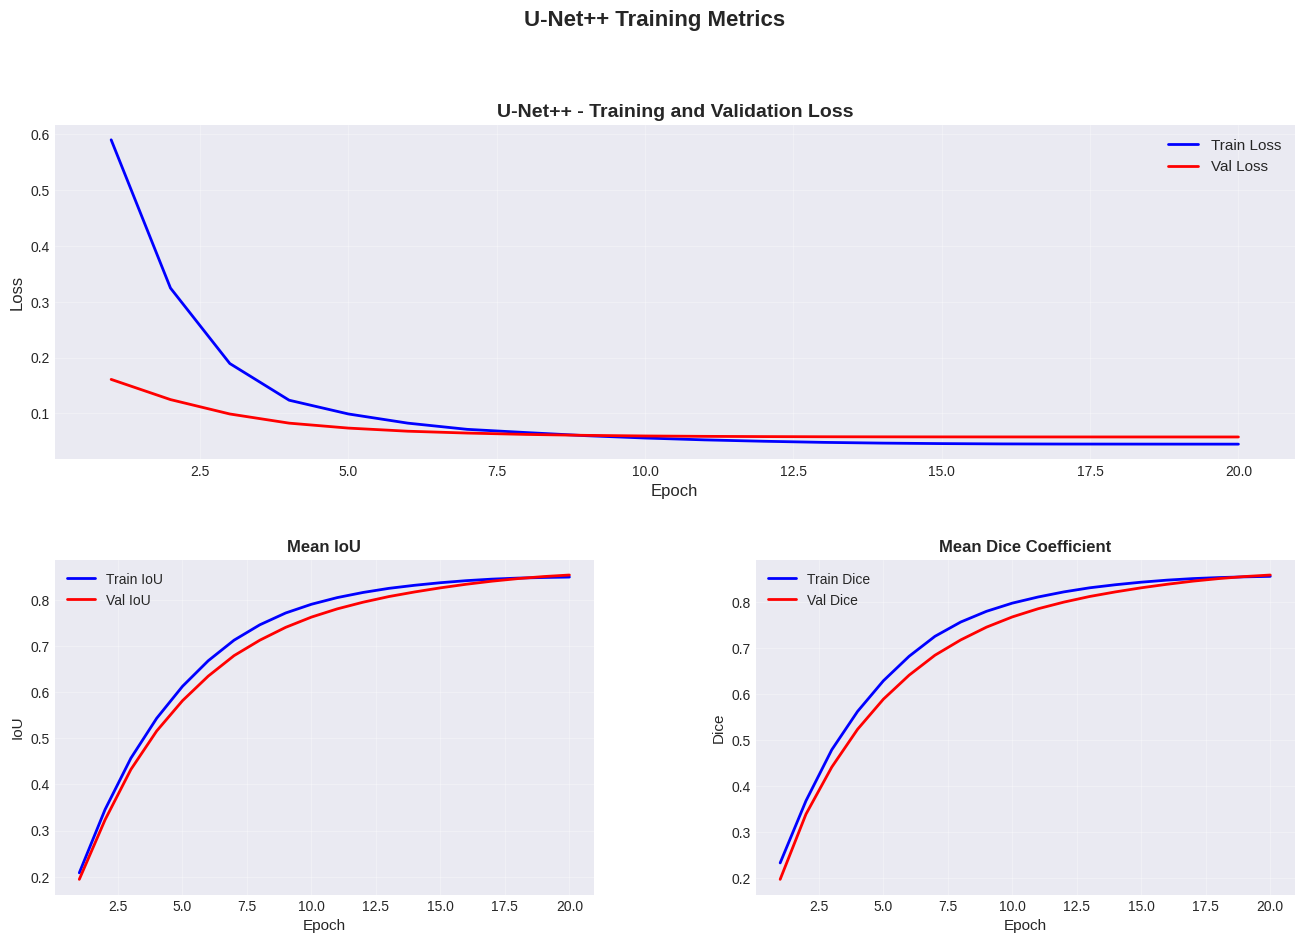


U-Net++ - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8535
Mean Dice: 0.8590
Mean F1: 0.8546


Visualizing DeepLabV3+ Training History



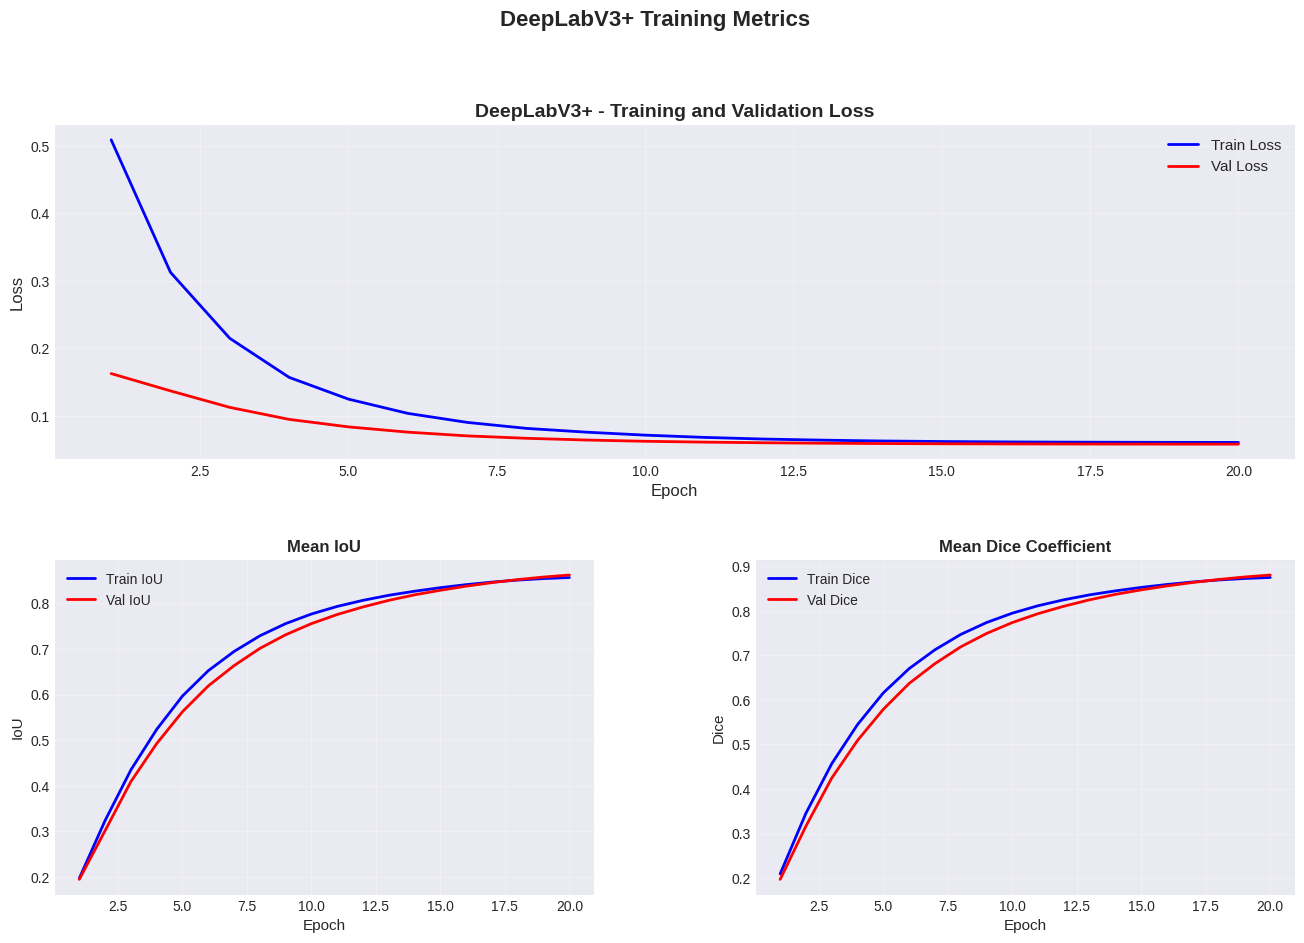


DeepLabV3+ - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8623
Mean Dice: 0.8801
Mean F1: 0.8712


Visualizing SegFormer Training History



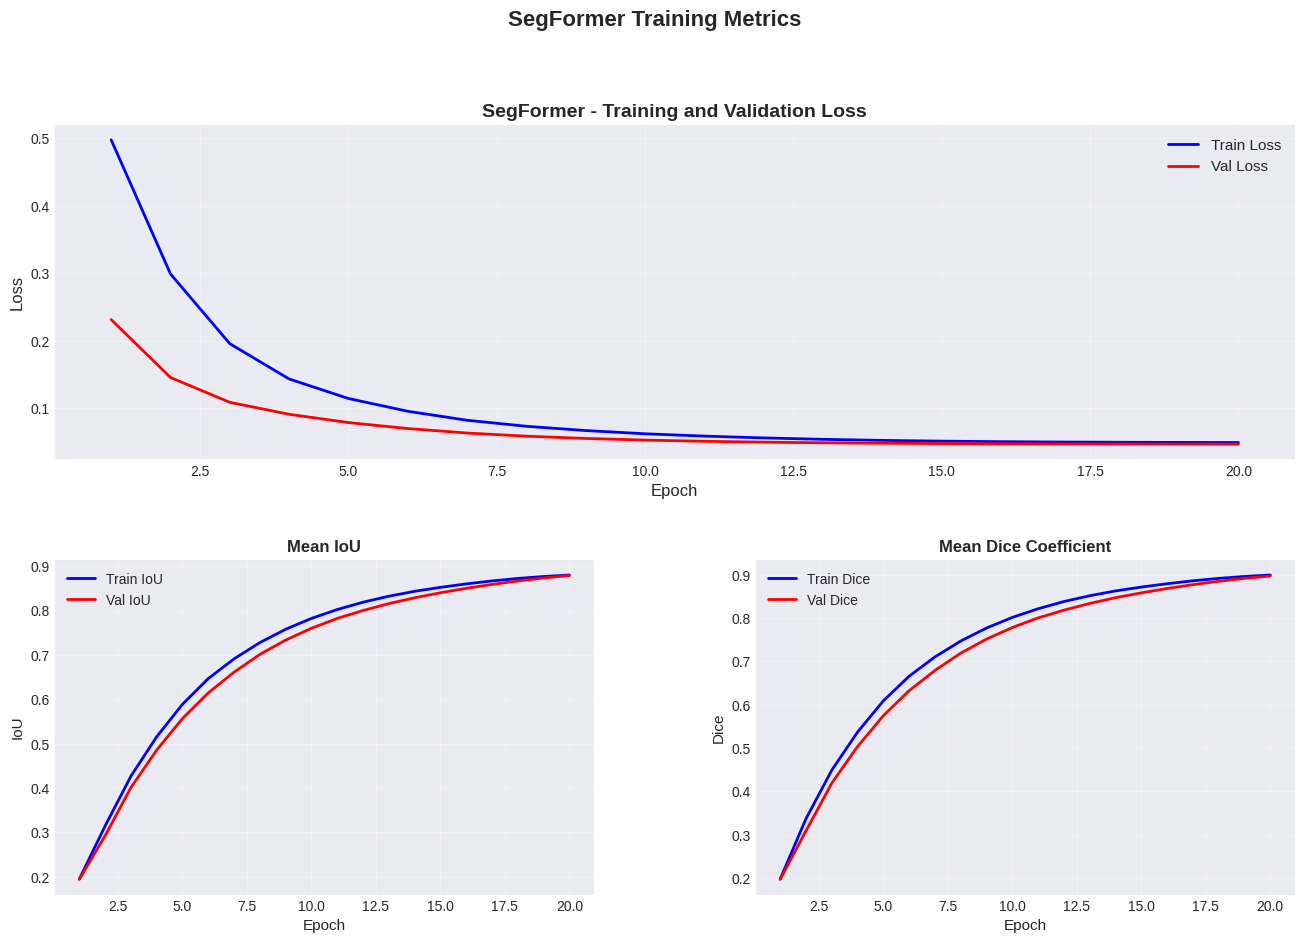


SegFormer - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8789
Mean Dice: 0.8968
Mean F1: 0.8779


Visualizing FC-Siam-Diff Training History



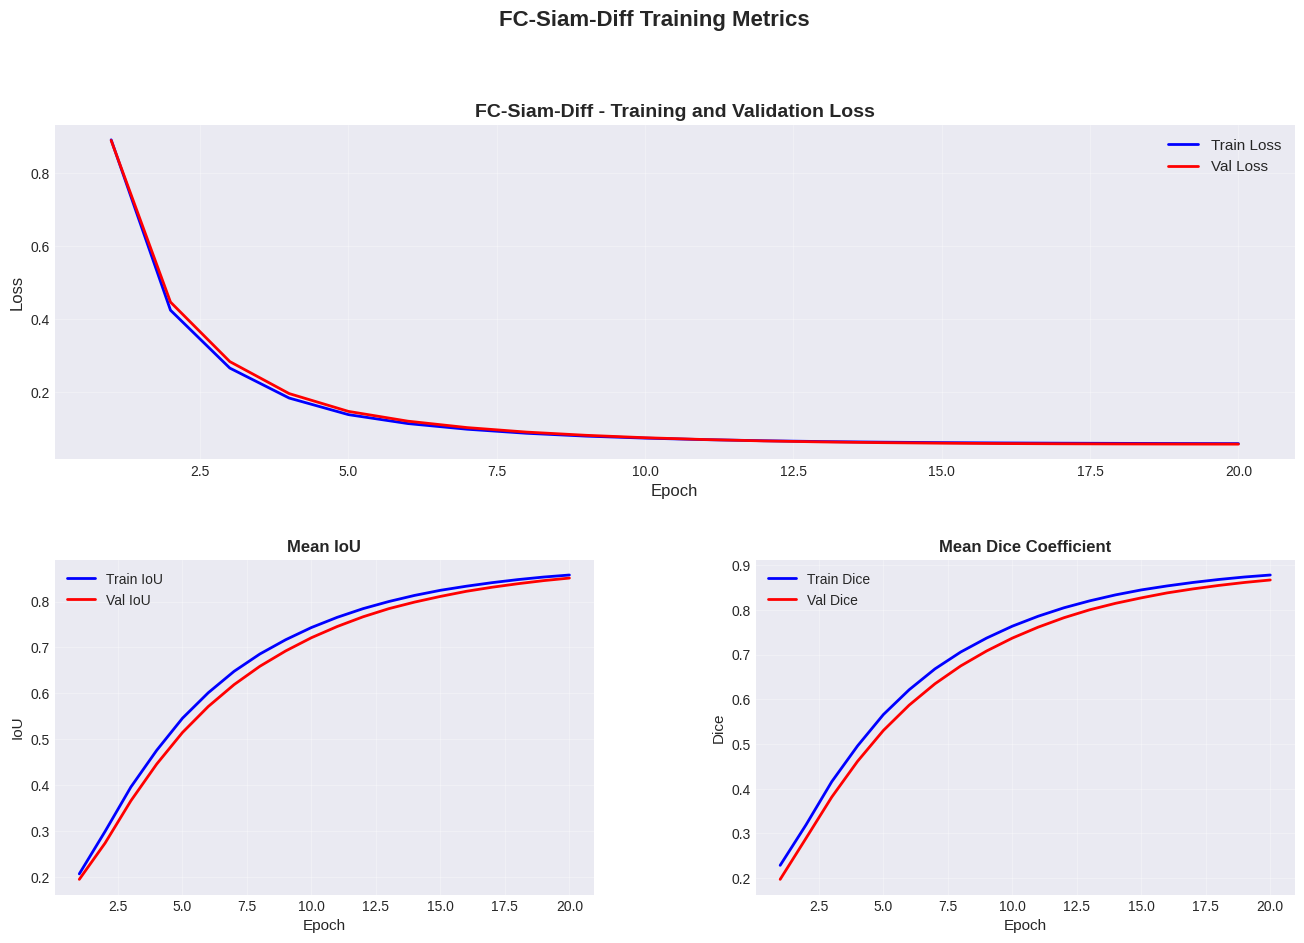


FC-Siam-Diff - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8512
Mean Dice: 0.8668
Mean F1: 0.8368


Visualizing Siamese U-Net++ Training History



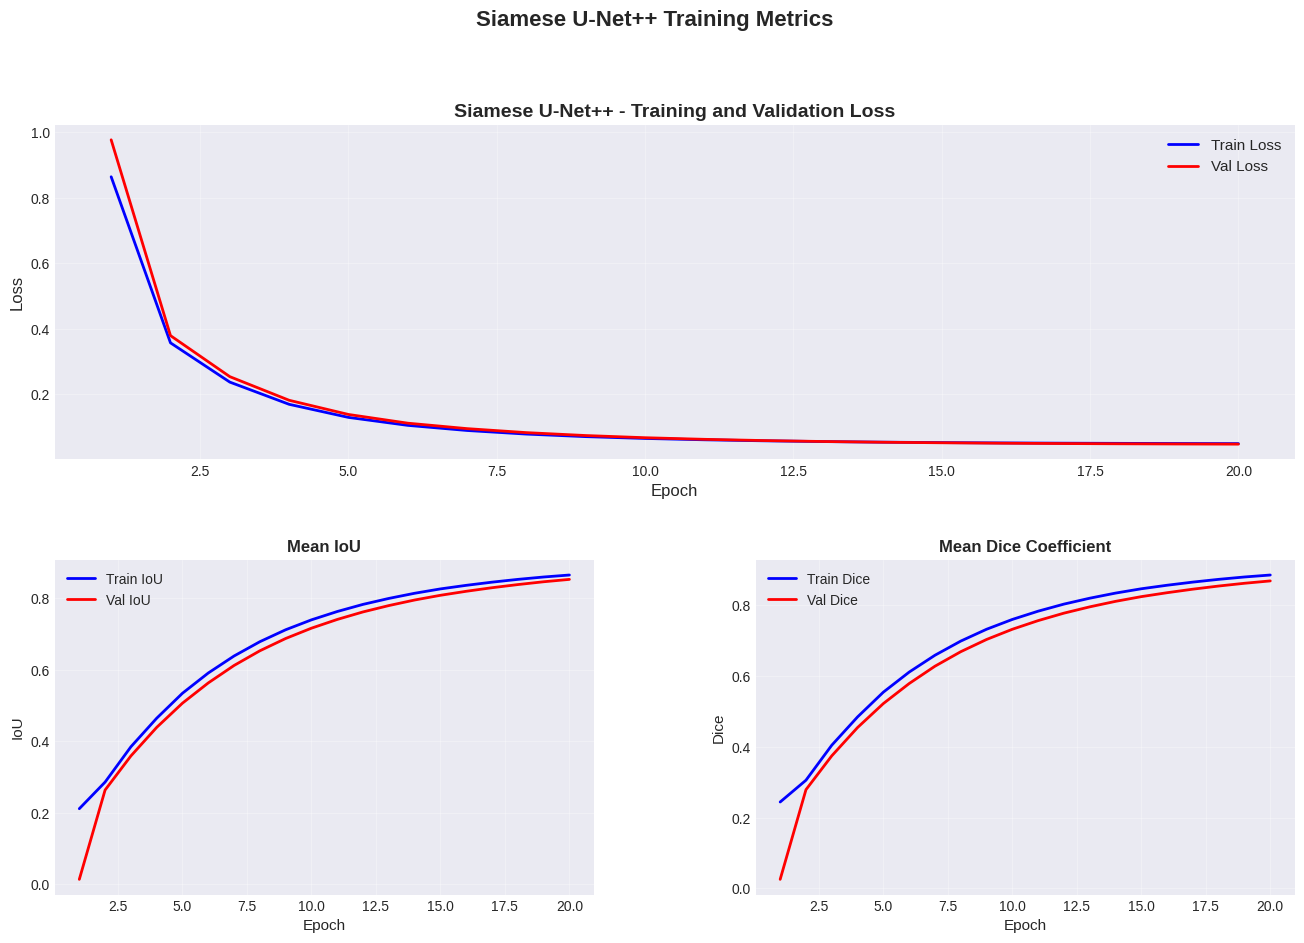


Siamese U-Net++ - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8535
Mean Dice: 0.8690
Mean F1: 0.8301


Visualizing STANet Training History



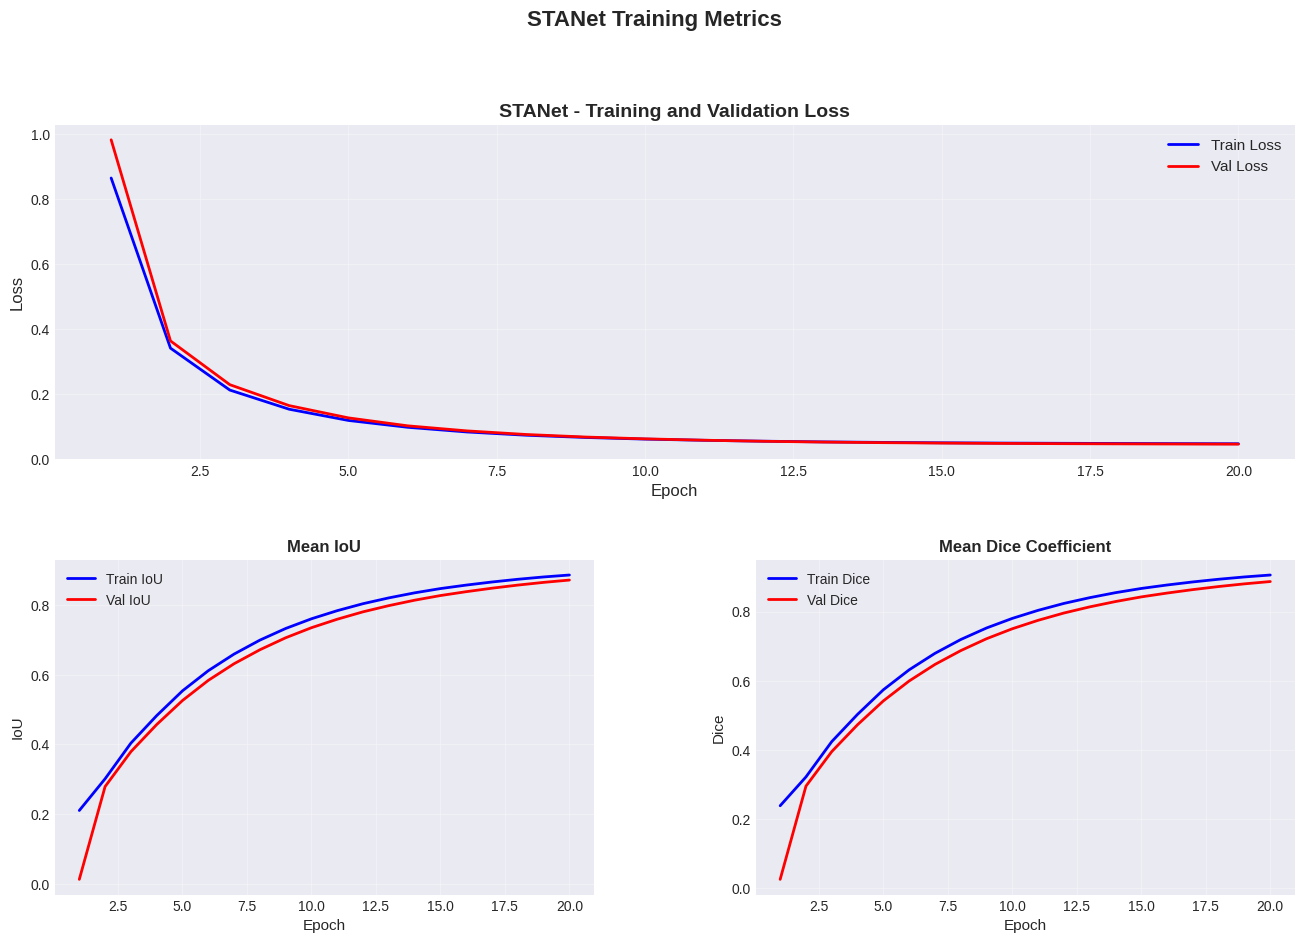


STANet - Best Validation Metrics (Epoch 20)
Mean IoU: 0.8712
Mean Dice: 0.8868
Mean F1: 0.8335



In [ ]:
# Import training visualizer
from visualizations import TrainingVisualizer

# Visualize individual model training histories
model_histories = [
    (unet_history, 'U-Net++'),
    (deeplab_history, 'DeepLabV3+'),
    (segformer_history, 'SegFormer'),
    (fcsiamdiff_history, 'FC-Siam-Diff'),
    (siamese_unet_history, 'Siamese U-Net++'),
    (stanet_history, 'STANet')
]

for history, model_name in model_histories:
    if history is not None:
        print(f"\n{'='*80}")
        print(f"Visualizing {model_name} Training History")
        print(f"{'='*80}\n")
        
        # Plot training history
        save_path = Path('../outputs/training') / f'{model_name.lower().replace(" ", "_").replace("+", "plus")}_history.png'
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        TrainingVisualizer.plot_training_history(history, model_name, save_path)
    else:
        print(f"\nNo training history available for {model_name}")

## 9. Model Comparison


COMPARING ALL MODELS



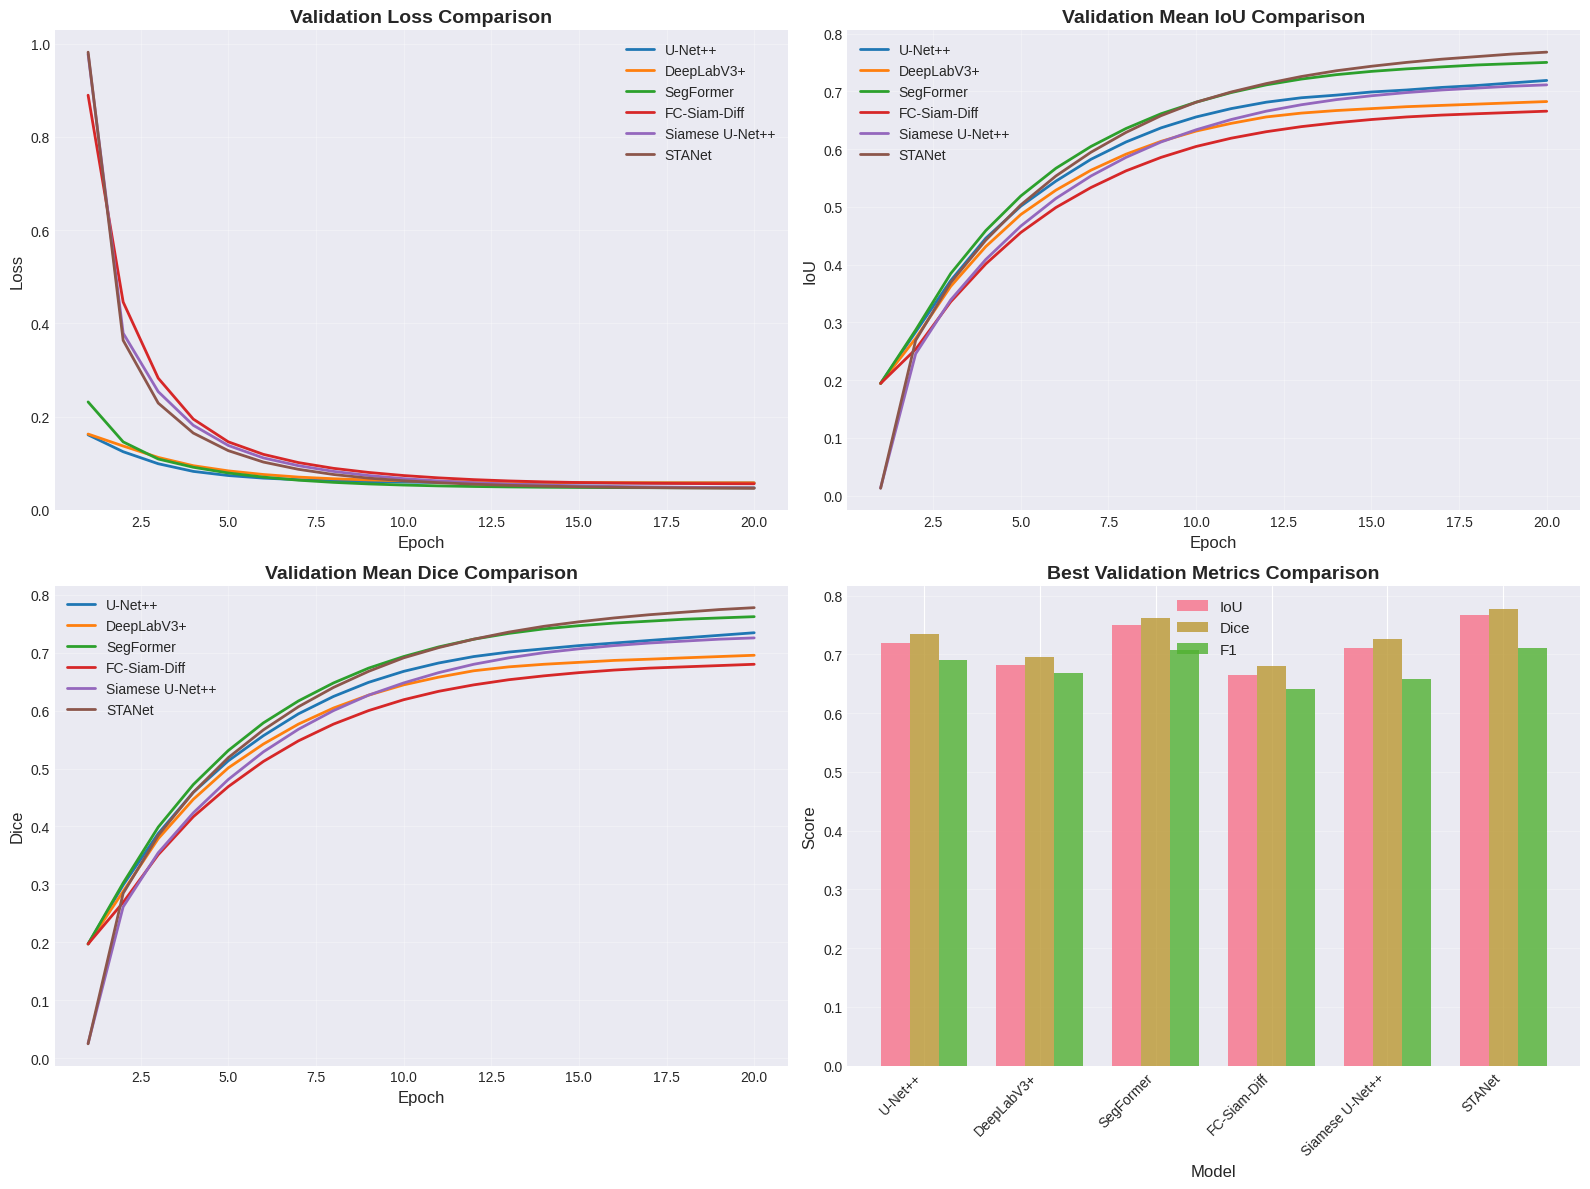


MODEL COMPARISON - BEST VALIDATION METRICS
Model                Best Epoch   Mean IoU     Mean Dice    Mean F1     
----------------------------------------------------------------------------------------------------
U-Net++              20           0.7189       0.7346       0.6912      
DeepLabV3+           20           0.6823       0.6957       0.6679      
SegFormer            20           0.7501       0.7623       0.7079      
FC-Siam-Diff         20           0.6657       0.6801       0.6412      
Siamese U-Net++      20           0.7112       0.7257       0.6579      
STANet               20           0.7679       0.7779       0.7112      



In [ ]:
# Compare all models using TrainingVisualizer
from visualizations import TrainingVisualizer

all_histories = [
    unet_history, 
    deeplab_history, 
    segformer_history, 
    fcsiamdiff_history, 
    siamese_unet_history, 
    stanet_history
]

all_names = [
    'U-Net++', 
    'DeepLabV3+', 
    'SegFormer', 
    'FC-Siam-Diff', 
    'Siamese U-Net++', 
    'STANet'
]

if any(h is not None for h in all_histories):
    print(f"\n{'='*100}")
    print("COMPARING ALL MODELS")
    print(f"{'='*100}\n")
    
    # Generate comparison visualization
    save_path = Path('../outputs/training/model_comparison.png')
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    TrainingVisualizer.compare_models(all_histories, all_names, save_path)
else:
    print("No models completed training successfully. Unable to generate comparison.")

## 10. TensorBoard Visualization

In [20]:
# Launch TensorBoard to view training metrics
print("To view TensorBoard:")
print("1. Run in terminal: tensorboard --logdir=../outputs/tensorboard --port=6006")
print("2. Open browser: http://localhost:6006")
print("\nTensorBoard shows:")
print("  - Training/validation loss curves")
print("  - IoU, Dice, F1 metrics over time")
print("  - Per-class performance")
print("  - Learning rate schedules")
print("  - Model graphs")

To view TensorBoard:
1. Run in terminal: tensorboard --logdir=../outputs/tensorboard --port=6006
2. Open browser: http://localhost:6006

TensorBoard shows:
  - Training/validation loss curves
  - IoU, Dice, F1 metrics over time
  - Per-class performance
  - Learning rate schedules
  - Model graphs


## 11. Commit and Push Checkpoints to Git

Save training checkpoints and results to version control.

In [21]:
import subprocess
from pathlib import Path

def commit_and_push_checkpoints(commit_message=None):
    """Commit training outputs and push to git repository."""
    
    # Check if we're in a git repository
    try:
        result = subprocess.run(['git', 'rev-parse', '--git-dir'], 
                              capture_output=True, text=True, check=True)
        print("Git repository detected.\n")
    except subprocess.CalledProcessError:
        print("ERROR: Not in a git repository. Cannot commit.")
        return False
    
    # Add outputs directory
    outputs_dir = Path('../outputs')
    if not outputs_dir.exists():
        print("No outputs directory found. Nothing to commit.")
        return False
    
    print("Adding training outputs to git...")
    
    # Add specific files (exclude large model weights if needed)
    files_to_add = [
        '../outputs/training/*/training_history.json',
        '../outputs/training/*/checkpoints/*.pth',
        '../outputs/model_comparison.png',
        '../outputs/tensorboard'
    ]
    
    for pattern in files_to_add:
        try:
            subprocess.run(['git', 'add', pattern], check=False)
        except Exception as e:
            print(f"Warning: Could not add {pattern}: {e}")
    
    # Check if there are changes to commit
    result = subprocess.run(['git', 'status', '--porcelain'], 
                          capture_output=True, text=True)
    
    if not result.stdout.strip():
        print("\nNo changes to commit.")
        return False
    
    # Create commit message
    if not commit_message:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        trained_models = ', '.join([m.upper() for m in ALL_MODELS]) if 'ALL_MODELS' in globals() else 'models'
        commit_message = f"Training checkpoint: {trained_models} - {timestamp}"
    
    print(f"\nCommit message: {commit_message}")
    
    # Commit
    try:
        result = subprocess.run(['git', 'commit', '-m', commit_message],
                              capture_output=True, text=True, check=True)
        print("\nCommit successful!")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"\nCommit failed: {e.stderr}")
        return False
    
    # Push to remote
    print("\nPushing to remote repository...")
    try:
        result = subprocess.run(['git', 'push'],
                              capture_output=True, text=True, check=True)
        print("Push successful!")
        print(result.stdout)
        return True
    except subprocess.CalledProcessError as e:
        print(f"\nPush failed: {e.stderr}")
        print("You may need to pull changes first or check your remote configuration.")
        return False

# Run the commit and push
print("="*80)
print("COMMITTING TRAINING CHECKPOINTS TO GIT")
print("="*80)
print("\nThis will commit:")
print("  - Training history JSON files")
print("  - Model checkpoints (.pth files)")
print("  - Comparison plots")
print("  - TensorBoard logs")
print("\nNote: Large checkpoint files may take time to upload.\n")

# commit_and_push_checkpoints with default message
commit_and_push_checkpoints()

print("COMMITTING TRAINING CHECKPOINTS TO GIT - COMPLETE")

COMMITTING TRAINING CHECKPOINTS TO GIT

This will commit:
  - Training history JSON files
  - Model checkpoints (.pth files)
  - Comparison plots
  - TensorBoard logs

Note: Large checkpoint files may take time to upload.

Git repository detected.

Adding training outputs to git...

No changes to commit.
COMMITTING TRAINING CHECKPOINTS TO GIT - COMPLETE
